In [2]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# All hyperparameters are listed in model.py you can change them there
from train import *
from model import *

%matplotlib inline

In [3]:
def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((  (input>threshold) .float() * target      ).float())
    FP = torch.sum ((  (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((~(input>threshold)).float() * target      ).float())
    TN = torch.sum (((~(input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
            
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    
    trg = np.array(target    .view(-1).cpu())
    prd = np.array(prediction.view(-1).cpu())
    
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='.')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '.')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '.')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

def read_celled_data(pathname, n_cells_hor, n_cells_ver):
        return torch.load(pathname
                             + str(n_cells_hor)
                             + "x"
                             + str(n_cells_ver))
    
class pipeline():
    def __init__(
                    self,
                    celled_data_x_path,
                    celled_data_y_path,
                    celled_data_path_for_freq_map,
                    n_cells_hor, 
                    n_cells_ver,
                    model_name,
                    testing_days,
                    heavy_quake_thres,
                    days_to_predict_before,
                    days_to_predict_after,
                    embedding_size,
                    hidden_state_size,
                    n_cycles,
                    learning_rate,
                    lr_decay,
                    start_lr_decay,
                    weight_decay,
                    earthquake_weight,
                    device,
                    batch_size=1,
                    shuffle=False,
                    num_workers=10
                ):
        
        self.celled_data_x_path = celled_data_x_path
        self.celled_data_y_path = celled_data_y_path
        self.celled_data_path_for_freq_map = celled_data_path_for_freq_map
        self.n_cells_hor = n_cells_hor
        self.n_cells_ver = n_cells_ver
        self.model_name = model_name
        self.testing_days = testing_days
        self.heavy_quake_thres = heavy_quake_thres
        self.days_to_predict_before = days_to_predict_before
        self.days_to_predict_after = days_to_predict_after
        self.embedding_size = embedding_size
        self.hidden_state_size = hidden_state_size
        self.n_cycles = n_cycles
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.start_lr_decay = start_lr_decay
        self.weight_decay = weight_decay
        self.earthquake_weight = earthquake_weight
        self.device = device
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
    
    def get_celled_data_x_y(self):
        self.celled_data_x = read_celled_data(self.celled_data_x_path, self.n_cells_hor, self.n_cells_ver)
        self.celled_data_y = read_celled_data(self.celled_data_y_path, self.n_cells_hor, self.n_cells_ver)
        
        if self.celled_data_x.shape[1] == 1:
            self.two_maps_flag = False
        elif self.celled_data_x.shape[1] == 2:
            self.two_maps_flag = True
        
    def get_freq_map(self):
        freq_map_celled_data = read_celled_data(self.celled_data_path_for_freq_map, self.n_cells_hor, self.n_cells_ver)
        self.freq_map = (freq_map_celled_data>self.heavy_quake_thres).float().mean(dim=0)

    def get_train_test_datasets(self):
        self.dataset_train = Dataset_RNN_Train_different_xy(
                                    celled_data_x = self.celled_data_x,
                                    celled_data_y = self.celled_data_y,
                                    testing_days = self.testing_days,
                                    heavy_quake_thres = self.heavy_quake_thres,
                                    days_to_predict_before = self.days_to_predict_before,
                                    days_to_predict_after = self.days_to_predict_after
                                                            )
        
        self.dataset_test  = Dataset_RNN_Test_different_xy(
                                    celled_data_x = self.celled_data_x,
                                    celled_data_y = self.celled_data_y,
                                    testing_days = self.testing_days,
                                    heavy_quake_thres = self.heavy_quake_thres,
                                    days_to_predict_before = self.days_to_predict_before,
                                    days_to_predict_after = self.days_to_predict_after
                                                            )
        
    def get_train_test_dataloaders(self):
        self.dataloader_train = DataLoader(
                                            self.dataset_train,
                                            batch_size = self.batch_size,
                                            shuffle = self.shuffle,
                                            num_workers = self.num_workers
                                          )
        self.dataloader_test  = DataLoader(
                                            self.dataset_test,
                                            batch_size = self.batch_size,
                                            shuffle = self.shuffle,
                                            num_workers = self.num_workers
                                          )
        
    def save_model(self):
        if not os.path.exists("../data/model"):
            os.mkdir("../data/model")
        torch.save(self.model.state_dict(), f"../data/model/{self.model_name}")
        
    def init_model(self):
        if self.two_maps_flag == False:
            self.model = LSTMCell(
                                    frequency_map = self.freq_map,
                                    embedding_size    = self.embedding_size,
                                    hidden_state_size = self.hidden_state_size,
                                    n_cells_hor       = self.n_cells_hor,
                                    n_cells_ver       = self.n_cells_ver,
                                    device            = self.device
                                )
            
        elif self.two_maps_flag == True:
            self.model = LSTMCell_density(
                                            frequency_map = self.freq_map,
                                            embedding_size    = self.embedding_size,
                                            hidden_state_size = self.hidden_state_size,
                                            n_cells_hor       = self.n_cells_hor,
                                            n_cells_ver       = self.n_cells_ver,
                                            device            = self.device
                                        )
        
    def train(self):
        self.model.train()
        train_RNN_full(
                           self.model,
                           self.device,
                           self.dataloader_train,
                           n_cycles = self.n_cycles,
                           learning_rate = self.learning_rate,
                           earthquake_weight = self.earthquake_weight,
                           lr_decay = self.lr_decay,
                           start_lr_decay = self.start_lr_decay,
                           weight_decay = self.weight_decay
                      )
        
        self.save_model()
        
    def validate(self):
        self.model.eval()
        ROC_AUC, AVG_prec = check_quality(
                                                self.model,
                                                device,
                                                self.dataloader_test,
                                                n_dots=251
                                         )
        
    def __call__(self):
        print('initializing datasets, dataloaders, model . . . ')
        self.get_celled_data_x_y()
        self.get_freq_map()
        self.get_train_test_datasets()
        self.get_train_test_dataloaders()
        self.init_model()
        
        print('\ntraining . . .')
        self.train()
        
        print('\nvalidating . . .')
        self.validate()

In [23]:
N_CELLS_HOR = 200
N_CELLS_VER = 250
HEAVY_QUAKE_THRES = 3.5
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

# исходное разбиение
CELLED_DATA_PATH_CAT_ORIG_SRC = "../data/celled_data_cat_orig_"
CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC = "../data/celled_data_without_aft_cat"
# исходное разбиение с картой плотности
CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY = "../data/celled_data_cat_orig_src_density"
CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY = "../data/celled_data_without_aft_catsrc_density"
# разбиение с максимальной магнитудой
CELLED_DATA_PATH_CAT_ORIG_MAXMAGN = "../data/celled_data_cat_orig_maxmagn"
CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN = "../data/celled_data_without_aft_cat_maxmagn"
# разбиениес с картой плотности и максимальной магнитудой
CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY = "../data/celled_data_cat_orig_maxmagn_density"
CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY = "../data/celled_data_without_aft_cat_maxmagn_density"


# модели 
magn = str(HEAVY_QUAKE_THRES).replace('.', '_')
MODEL_NAME = 'state_dict'  # модель из статьи
# исходное разбиение
MODEL_Xorig_Yorig = f'model_src_Xorig_Yorig_magn{magn}'
MODEL_Xorig_Ywithoutaft = f'model_src_Xorig_Ywithoutaft_magn{magn}'
MODEL_Xwithoutaft_Yorig = f'model_src_Xwithoutaft_Yorig_magn{magn}'
MODEL_Xwithoutaft_Ywithoutaft = f'model_src_Xwithoutaft_Ywithoutaft_magn{magn}'
# исходное разбиение с картой плотности
MODEL_SRC_DENSITY_Xorig_Yorig = f'model_src_density_Xorig_Yorig_magn{magn}'
MODEL_SRC_DENSITY_Xorig_Ywithoutaft = f'model_src_density_Xorig_Ywithoutaft_magn{magn}'
MODEL_SRC_DENSITY_Xwithoutaft_Yorig = f'model_src_density_Xwithoutaft_Yorig_magn{magn}'
MODEL_SRC_DENSITY_Xwithoutaft_Ywithoutaft = f'model_src_density_Xwithoutaft_Ywithoutaft_magn{magn}'
# разбиение с максимальной магнитудой
MODEL_MAXMAGN_Xorig_Yorig = f'model_maxmagn_Xorig_Yorig_magn{magn}'
MODEL_MAXMAGN_Xorig_Ywithoutaft = f'model_maxmagn_Xorig_Ywithoutaft_magn{magn}'
MODEL_MAXMAGN_Xwithoutaft_Yorig = f'model_maxmagn_Xwithoutaft_Yorig_magn{magn}'
MODEL_MAXMAGN_Xwithoutaft_Ywithoutaft = f'model_maxmagn_Xwithoutaft_Ywithoutaft_magn{magn}'
# разбиениес с картой плотности и максимальной магнитудой
MODEL_MAXMAGN_DENSITY_Xorig_Yorig = f'model_maxmagn_density_Xorig_Yorig_magn{magn}'
MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft = f'model_maxmagn_density_Xorig_Ywithoutaft_magn{magn}'
MODEL_MAXMAGN_DENSITY_Xwithoutaft_Yorig = f'model_maxmagn_density_Xwithoutaft_Yorig_magn{magn}'
MODEL_MAXMAGN_DENSITY_Xwithoutaft_Ywithoutaft = f'model_maxmagn_density_Xwithoutaft_Ywithoutaft_magn{magn}'

In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(f"device: {device}")

PyTorch version: 1.3.1
GPU available: True
device: cuda:0


## Исходное разбиение 1 карта — магнитуда

### эксперимент 1

исходное разбиение — 1 карта магнитуды <br>
x — оригинальный каталог <br>
y — оригинальный каталог <br>

Done : 60100 / 60160


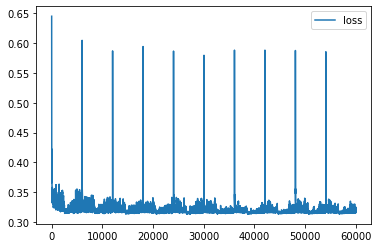


validating . . .



ROC_AUC_score = 0.9004765017002223
AVG_precision_score = 0.027989659658918784


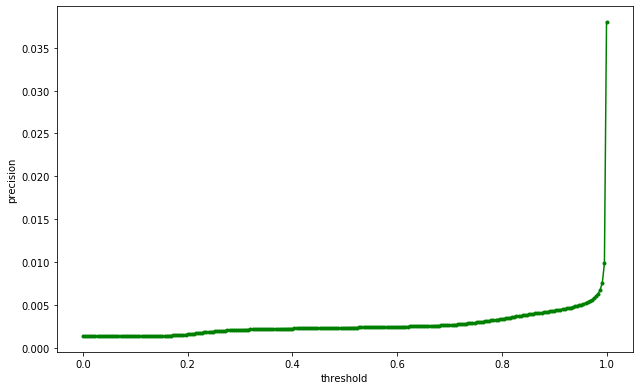

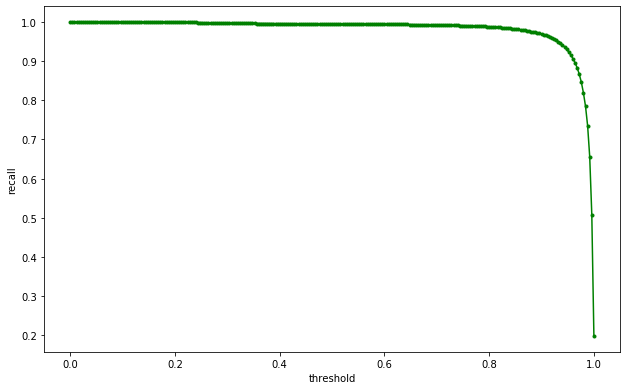

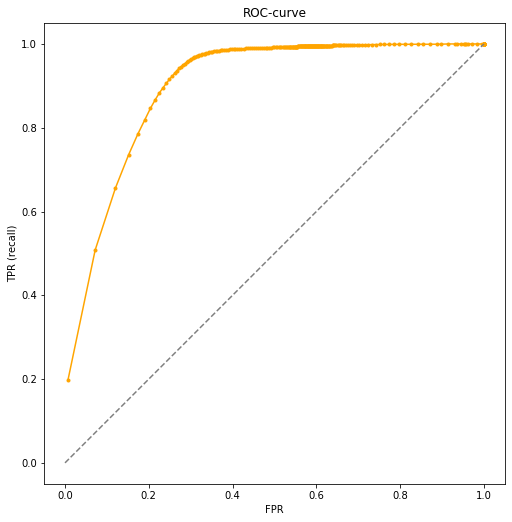

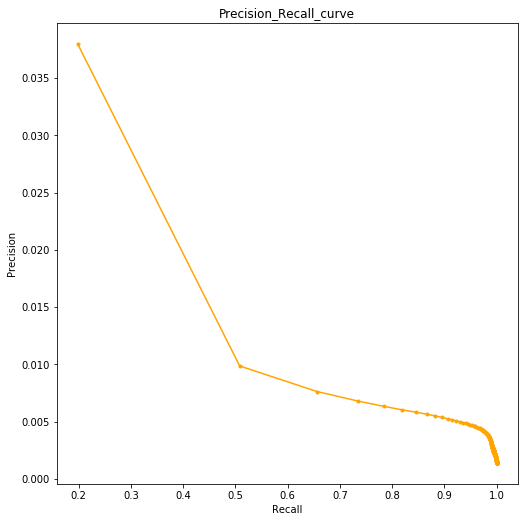

In [34]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

x_orig_y_orig_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        model_name = MODEL_Xorig_Yorig,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_orig_y_orig_src_pipeline()

1 cycle: <br>

    lr 1e-4 lr_decay 2
    - ROC_AUC_score = 0.89
    - AVG_precision_score = 
    
5 cycles: <br>

    lr 1e-4 lr_decay 2
    - ROC_AUC_score = 0.9035326266331725
    - AVG_precision_score = 0.02744365067610653

    lr 1e-3 lr_decay 2 start_lr_decay 10 eq_weight 10e5
    - ROC_AUC_score = 0.9081544836889519
    - AVG_precision_score = 0.02970437510124481
    
7 cycles: <br>
    
    lr 1e-4 lr_decay 5
    - ROC_AUC_score = 0.9113415048232717
    - AVG_precision_score = 0.028630668712885433

лучший результат <br>
ROC_AUC_score = __0.9113415048232717__ <br>
AVG_precision_score = __0.028630668712885433__

### эксперимент 2

исходное разбиение — 1 карта магнитуды <br>
x — оригинальный каталог <br>
y — каталог без афтершоков <br>

Done : 42100 / 42112


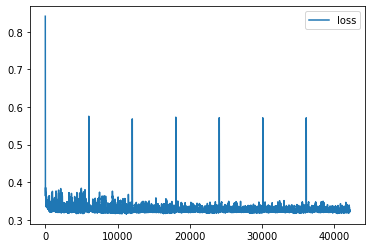


validating . . .



ROC_AUC_score = 0.8371759816220259
AVG_precision_score = 0.0026890648254800638


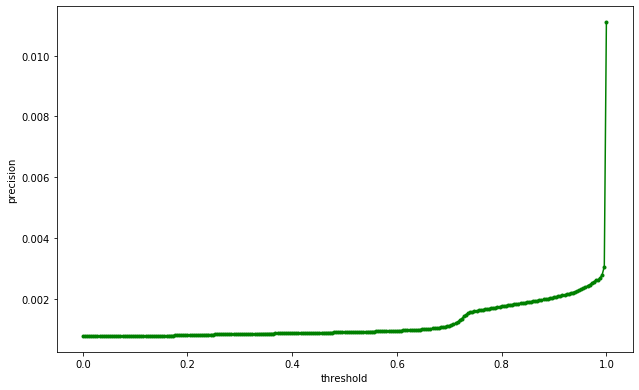

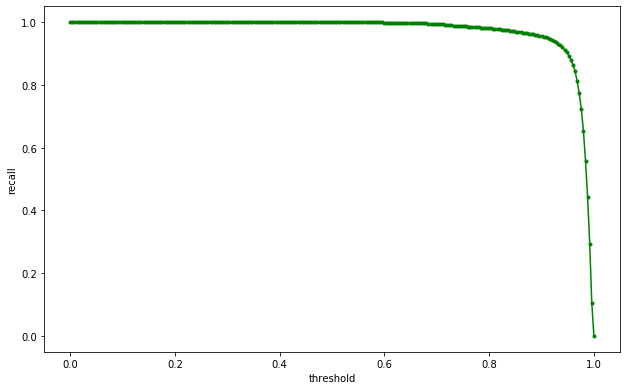

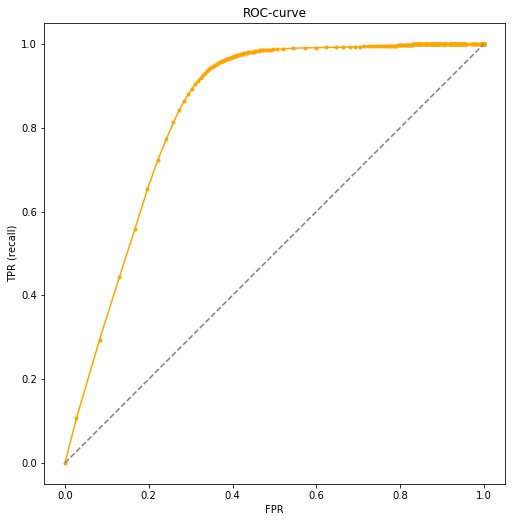

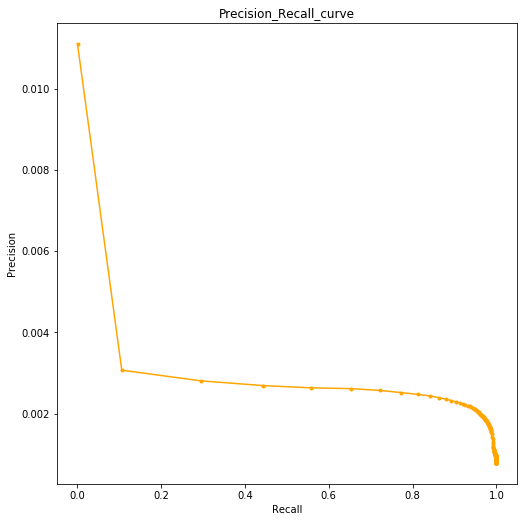

In [35]:
N_CYCLES = 7
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_orig_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_orig_y_withoutaft_src_pipeline()

Done : 30000 / 30080


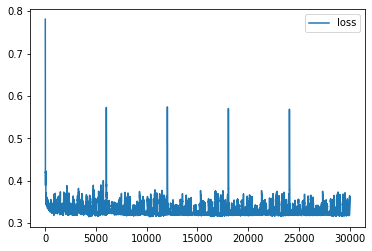


validating . . .



ROC_AUC_score = 0.8437587767567333
AVG_precision_score = 0.0028274161070218815


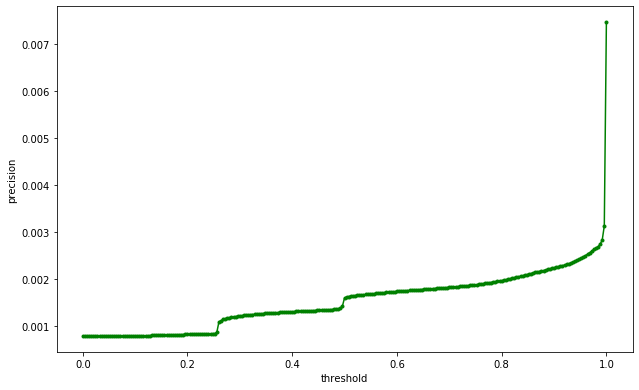

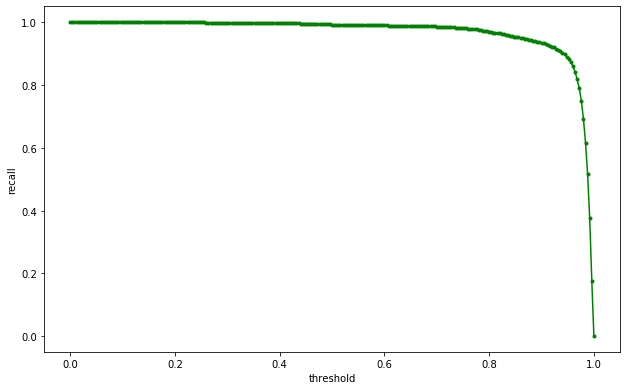

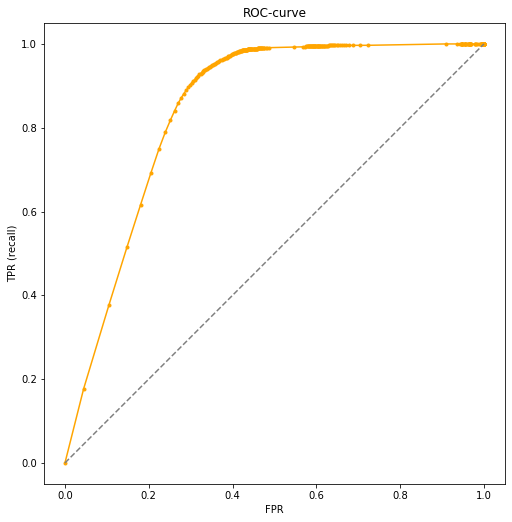

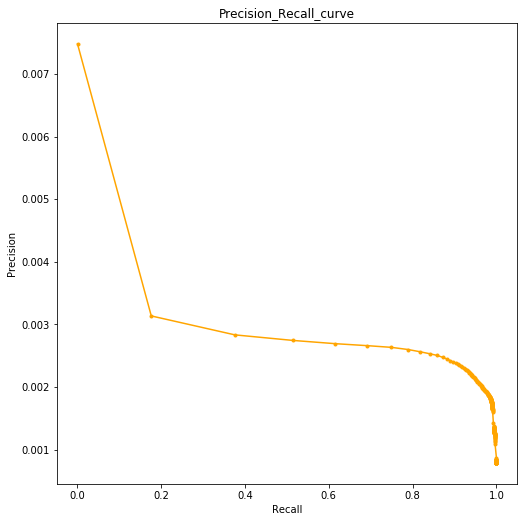

In [36]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_orig_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_orig_y_withoutaft_src_pipeline()

Done : 60100 / 60160


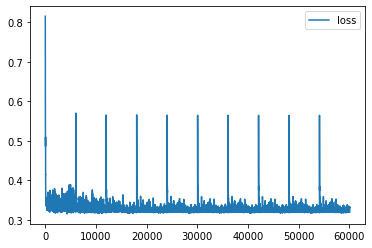


validating . . .



ROC_AUC_score = 0.8384821763789317
AVG_precision_score = 0.002799895016150262


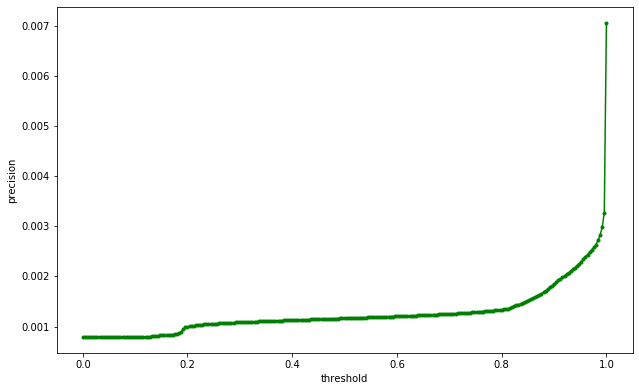

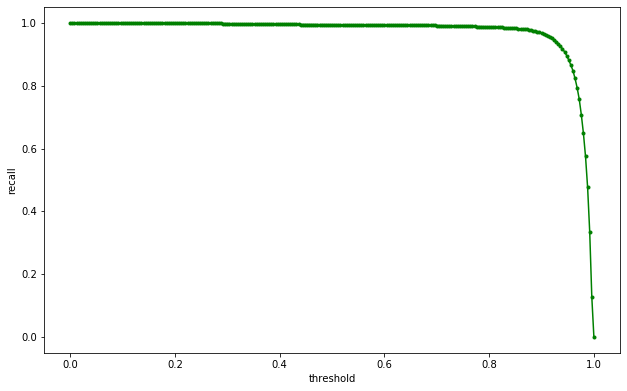

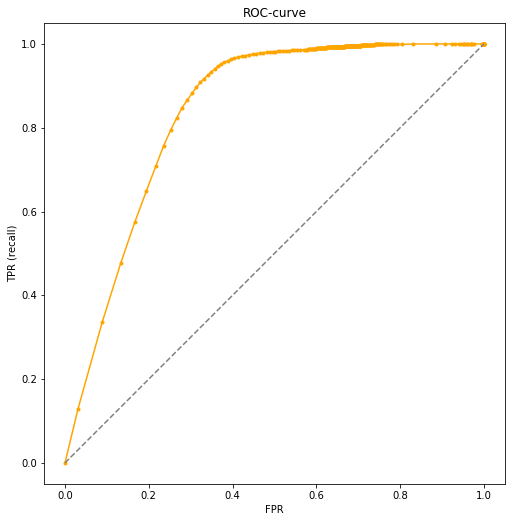

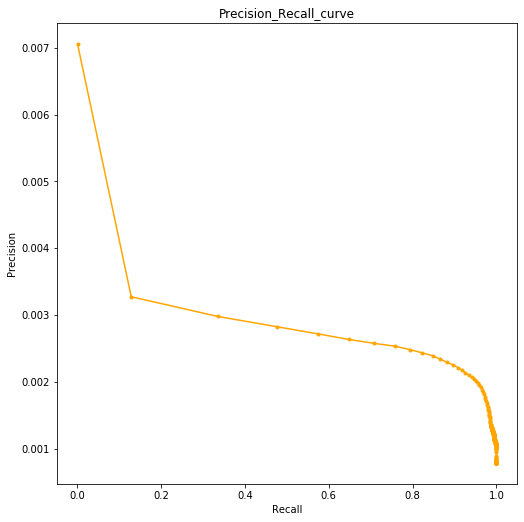

In [37]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_orig_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_orig_y_withoutaft_src_pipeline()

Done : 42100 / 42112


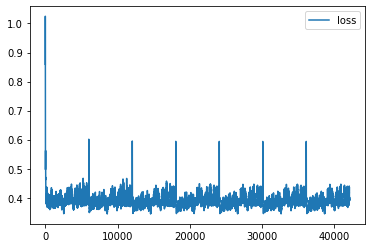


validating . . .



ROC_AUC_score = 0.8531819908751488
AVG_precision_score = 0.003176825941896503


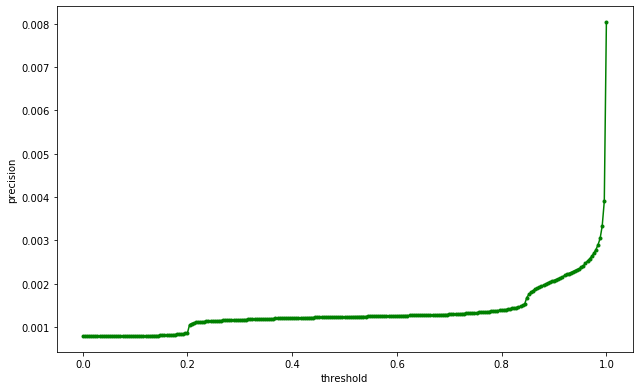

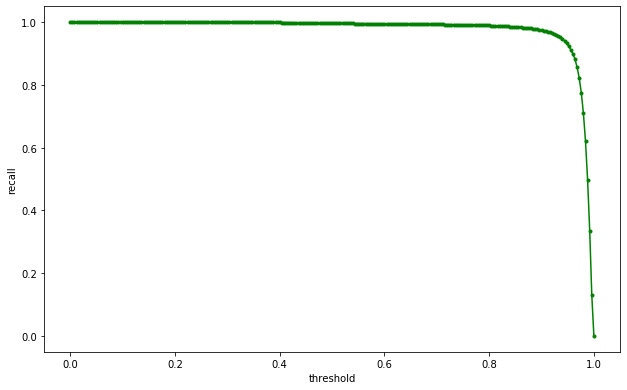

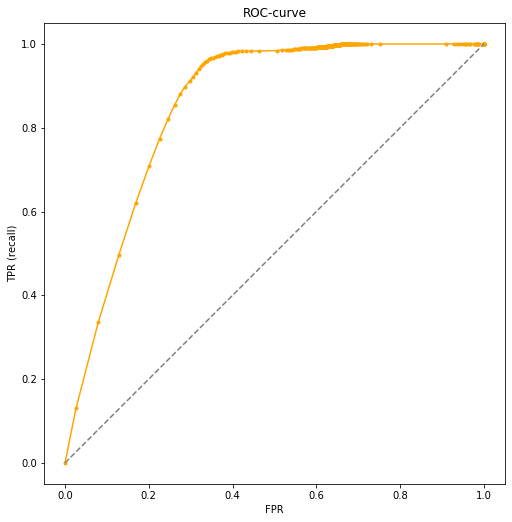

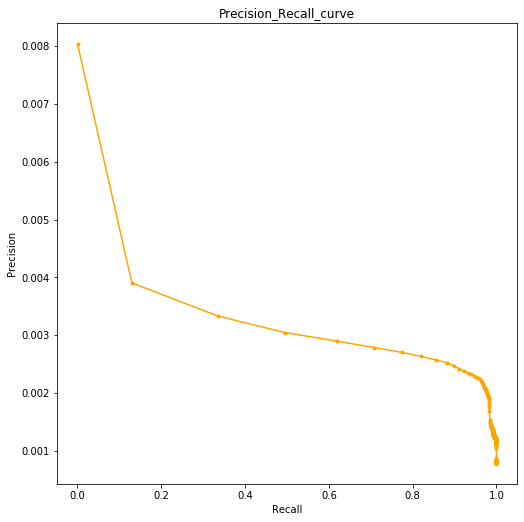

In [87]:
# 7 cycles 1e-4 lr_decay 10
x_orig_y_withoutaft_src_pipeline()

1 cycles: <br>

    lr 1e-4 lr_decay 5
    - ROC_AUC_score = 0.8404860346381675
    - AVG_precision_score = 0.0029147122826514555
    
5 cycles: <br>
    
    lr 1e-4 lr_decay 2
    - ROC_AUC_score = 0.847607221197609
    - AVG_precision_score = 0.003132973767642762
    
    lr 1e-4 lr_decay 5
    - ROC_AUC_score = 0.8592671357008771
    - AVG_precision_score = 0.0034531219683128275
    
    lr 1e-4 lr_decay 10
    - ROC_AUC_score = 0.8675600975089917
    - AVG_precision_score = 0.00354362003916202
    
7 cycles: <br>

    lr 1e-4 lr_decay 10
    - ROC_AUC_score = 0.8531819908751488
    - AVG_precision_score = 0.003176825941896503

лучший результат

ROC_AUC_score = __0.8675600975089917__ <br>
AVG_precision_score = __0.00354362003916202__

### эксперимент 3

исходное разбиение — 1 карта магнитуды <br>
x — каталог без афтершоков <br>
y — оригинальный каталог <br>

Done : 30000 / 30080


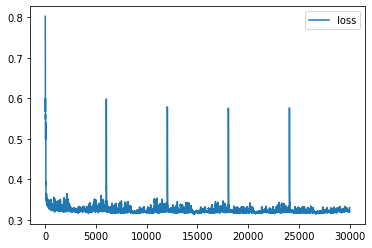


validating . . .



ROC_AUC_score = 0.8470305388821578
AVG_precision_score = 0.010275779894801773


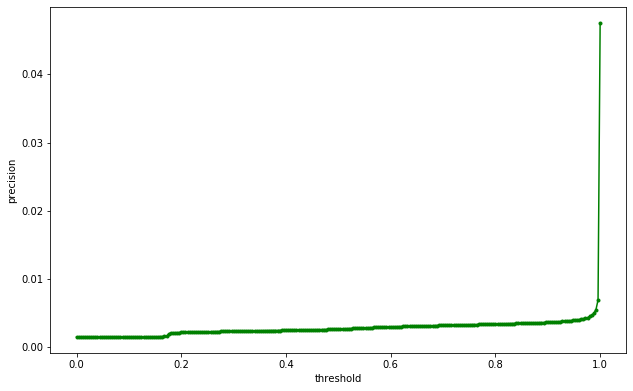

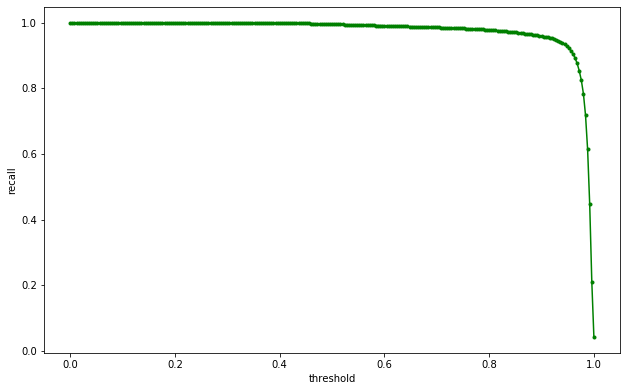

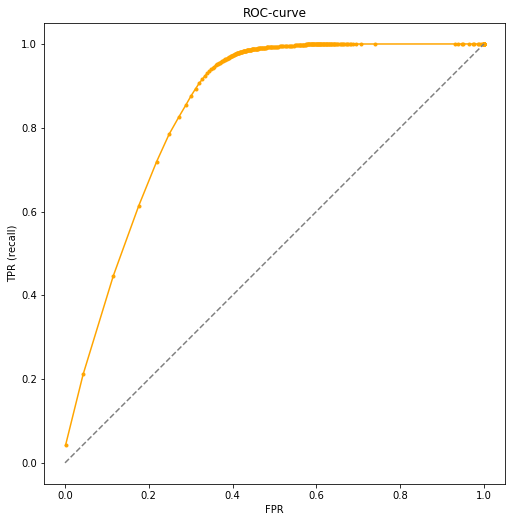

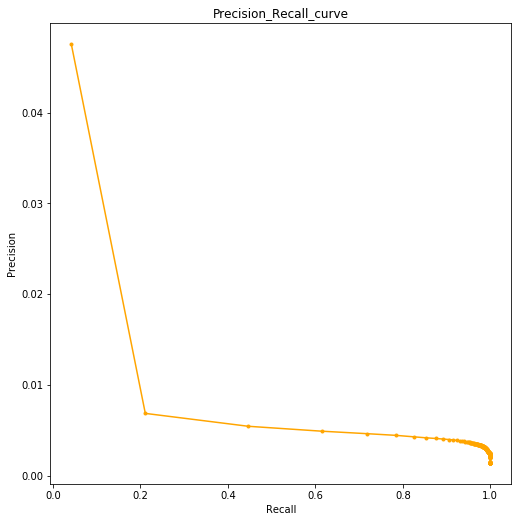

In [38]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

Done : 60100 / 60160


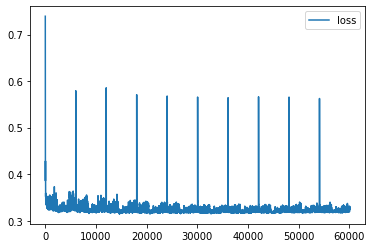


validating . . .



ROC_AUC_score = 0.854352424881991
AVG_precision_score = 0.012493849697016777


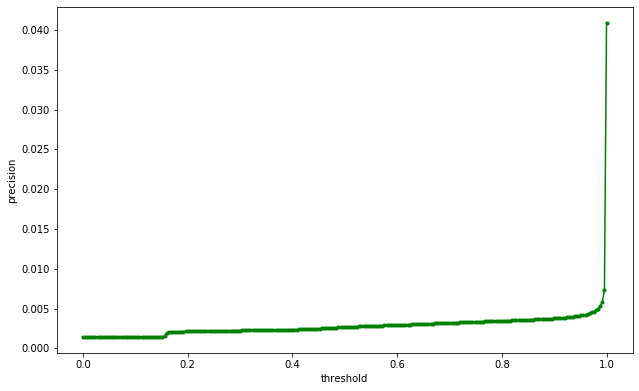

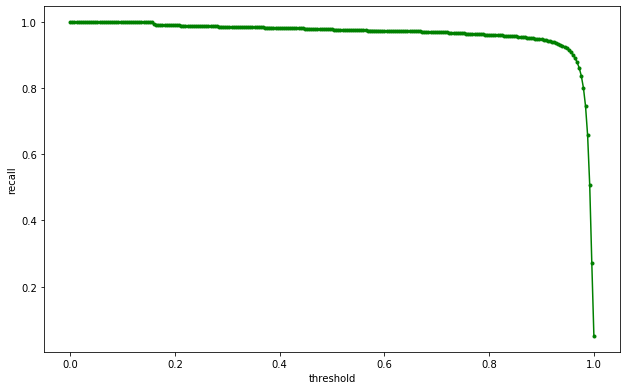

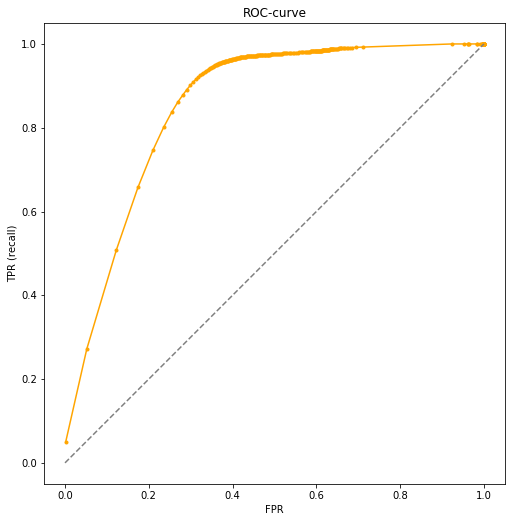

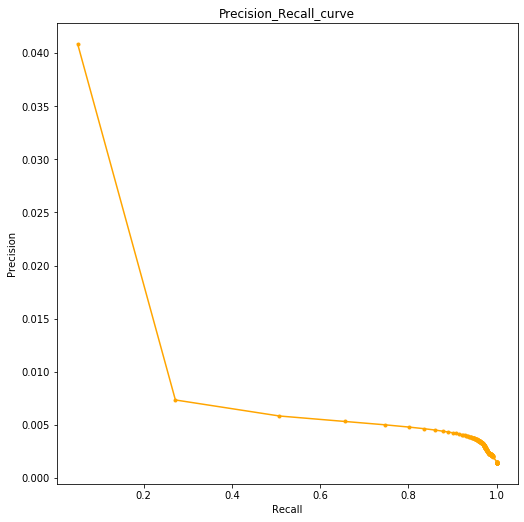

In [39]:
N_CYCLES =10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

5 cycles:
    
    lr 1e-4 lr_decay 10 start_lr_decay 110
    - ROC_AUC_score = 0.8477357748874855
    - AVG_precision_score = 0.007687075077629972
    
    lr 1e-4 lr_decay 2 start_lr_decay 10
    - ROC_AUC_score = 
    - AVG_precision_score = 
    
10 cycles:

    lr 1e-4 lr_decay 10 start_lr_decay 110
    - ROC_AUC_score = 0.8488079583881413
    - AVG_precision_score = 0.00864142031718863

лучший результат
ROC_AUC_score = __0.854352424881991__ <br>
AVG_precision_score = __0.012493849697016777__

### эксперимент 4

исходное разбиение — 1 карта магнитуды <br>
x — каталог без афтершоков <br>
y — каталог без афтершоков <br>

Done : 30000 / 30080


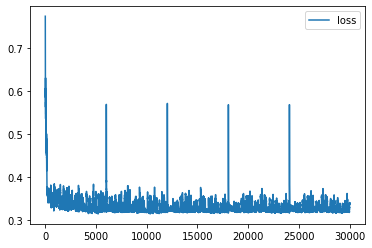


validating . . .



ROC_AUC_score = 0.8530546211113127
AVG_precision_score = 0.003580725677246685


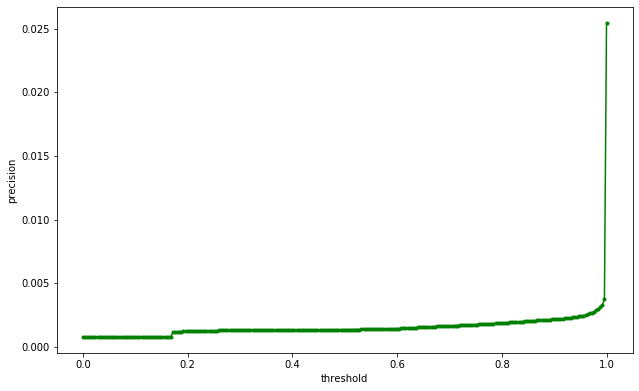

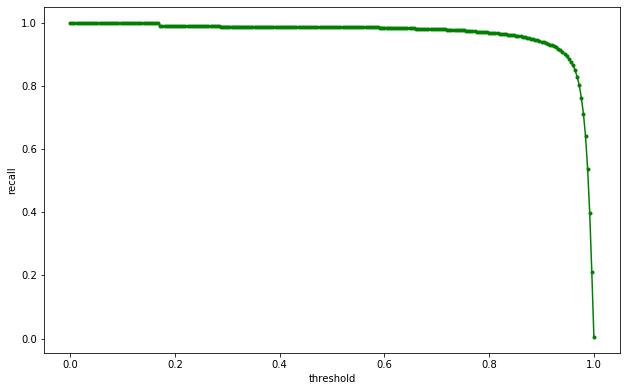

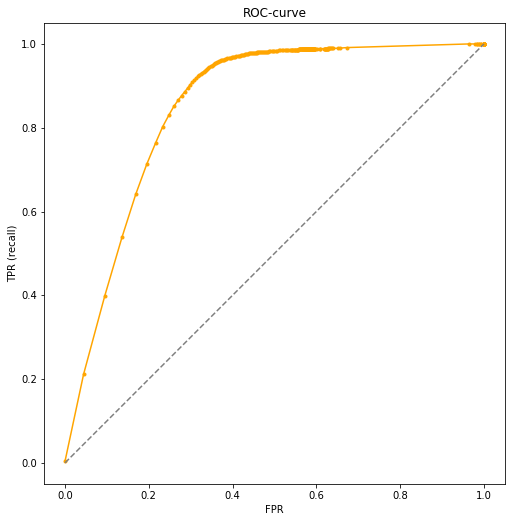

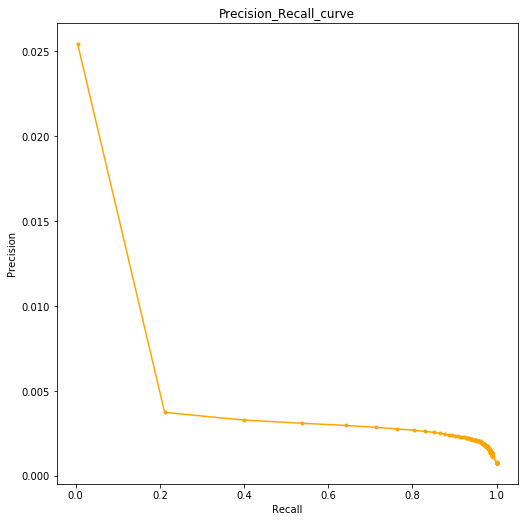

In [40]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_withoutaft_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_withoutaft_y_withoutaft_src_pipeline()

Done : 30000 / 30080


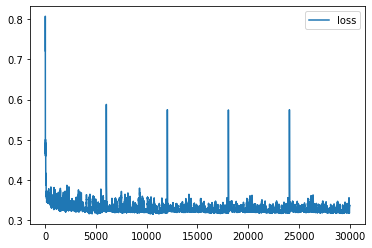


validating . . .



ROC_AUC_score = 0.848897312661701
AVG_precision_score = 0.0034603682779636956


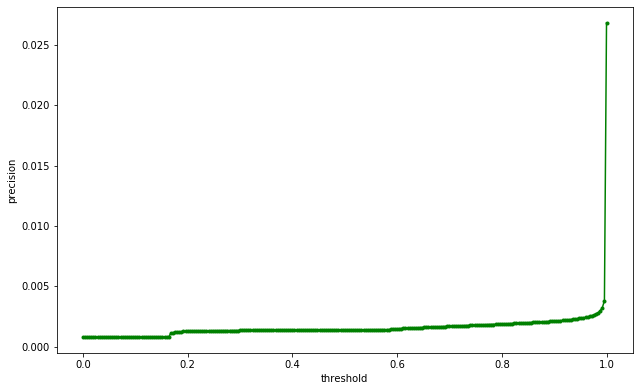

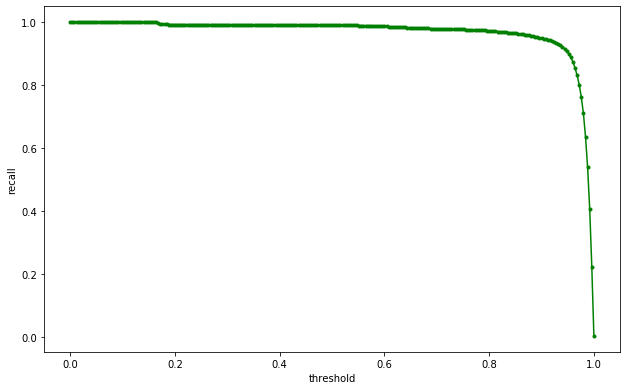

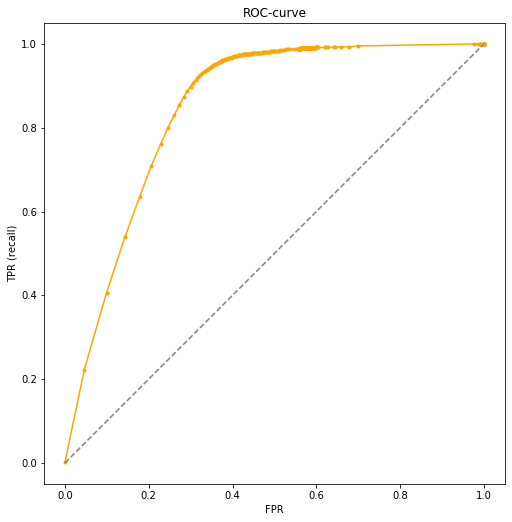

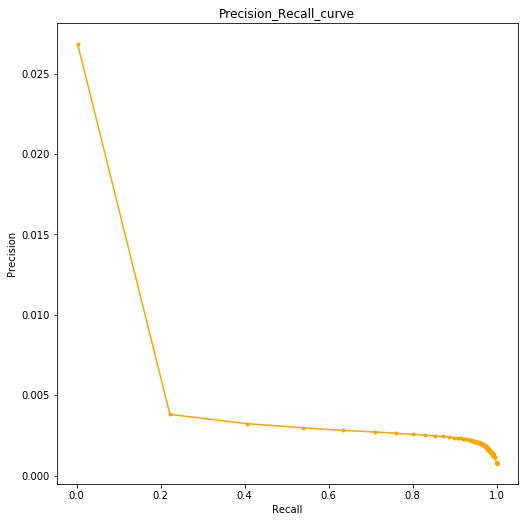

In [41]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_withoutaft_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_withoutaft_y_withoutaft_src_pipeline()

5 cycles:
    
    lr 1e-4 lr_decay 10 start_lr_decay 110
    - ROC_AUC_score = 0.8712461069995345
    - AVG_precision_score = 0.004420842611408468
    
10 cycles:

    lr 1e-4 lr_decay 10 start_lr_decay 110
    - ROC_AUC_score = 0.8508729297239863
    - AVG_precision_score = 0.0036135967852923725

| data | X | Y | ROC_AUC | AVG_precision |
| --- | --- | --- | --- | --- |
| magnitude map | orig | orig | 0.911 | 0.029 |
| magnitude map | orig | without aft | 0.868 | 0.004 |
| magnitude map | without aft | orig | 0.849 | 0.009 |
| magnitude map | without aft | without aft | 0.871 | 0.004 |

## разбиение с 1 картой — максимальной магнитуды

### эксперимент 5

исходное разбиение — 1 карта максимальной магнитуды <br>
x — оригинальный аталог <br>
y — оригинальный каталог <br>

Done : 30000 / 30080


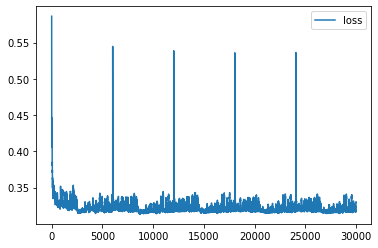


validating . . .



ROC_AUC_score = 0.9111387543170865
AVG_precision_score = 0.062601173603953


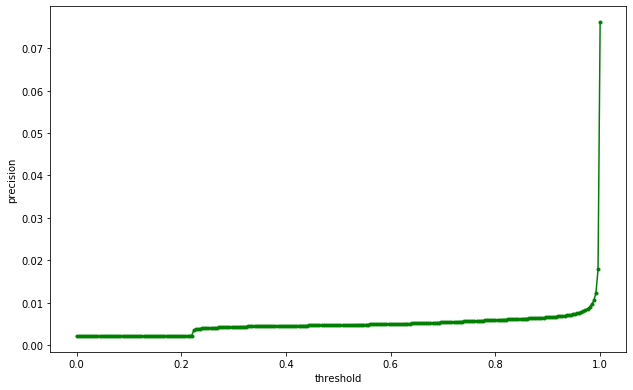

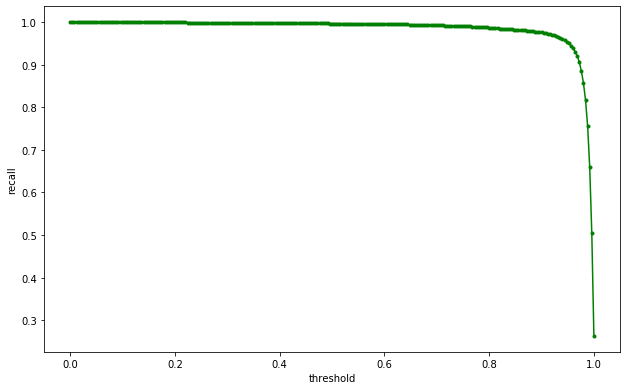

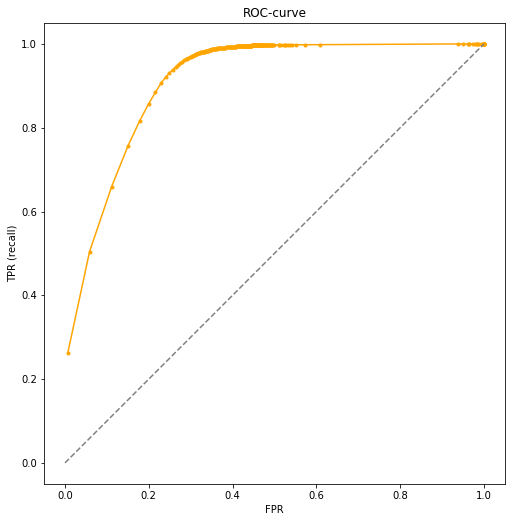

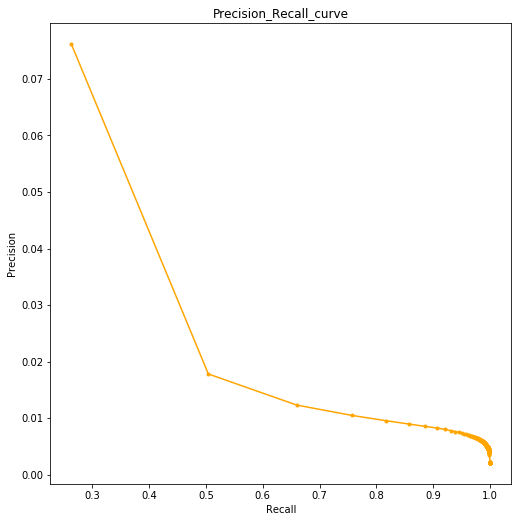

In [42]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_withoutaft_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_withoutaft_y_withoutaft_src_pipeline()

Done : 60100 / 60160


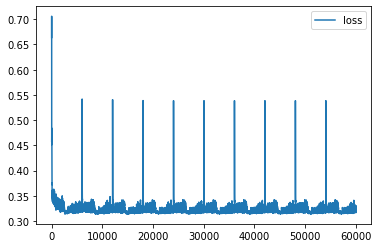


validating . . .



ROC_AUC_score = 0.9120614953263074
AVG_precision_score = 0.06556615248590744


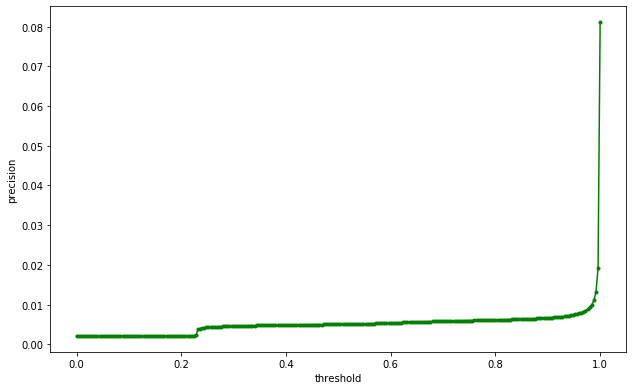

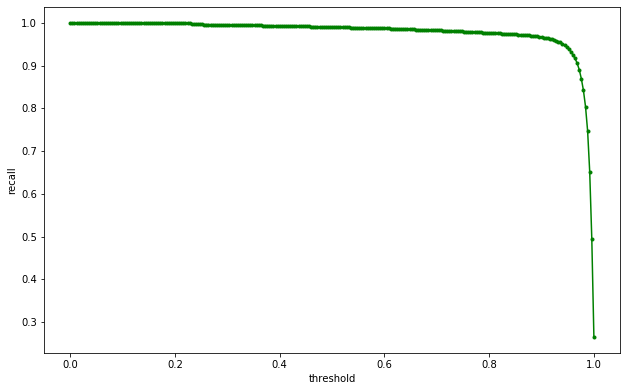

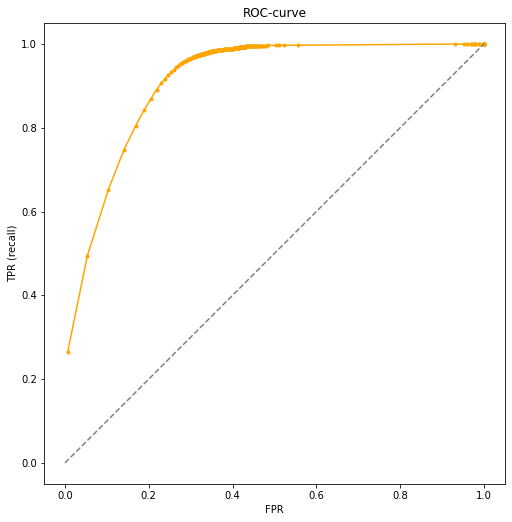

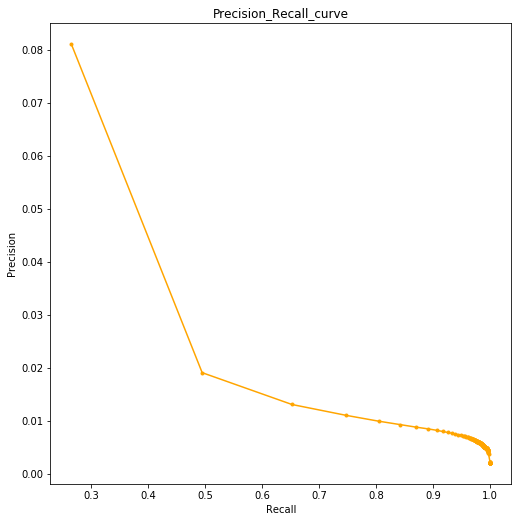

In [43]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 10.
START_LR_DECAY = 110
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

x_withoutaft_y_withoutaft_src_pipeline = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        model_name = MODEL_Xorig_Ywithoutaft,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

x_withoutaft_y_withoutaft_src_pipeline()

### эксперимент 6

исходное разбиение — 1 карта максимальной магнитуды <br>
x — оригинальный аталог <br>
y — каталог без афтершоков <br>

Done : 30000 / 30080


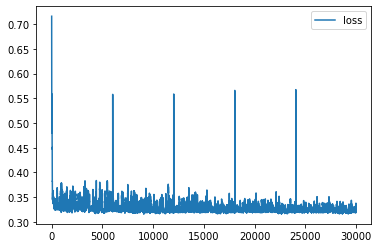


validating . . .



ROC_AUC_score = 0.8359837977051454
AVG_precision_score = 0.0031304876885090063


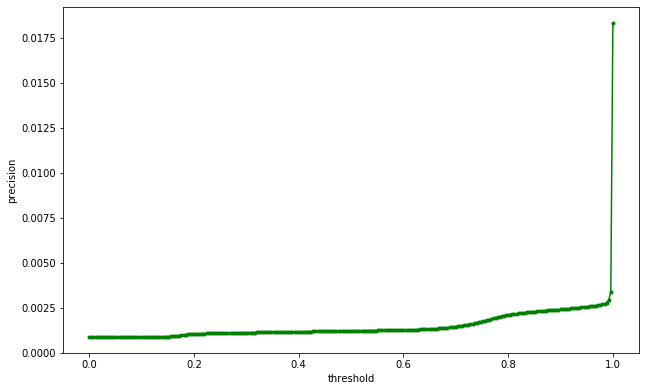

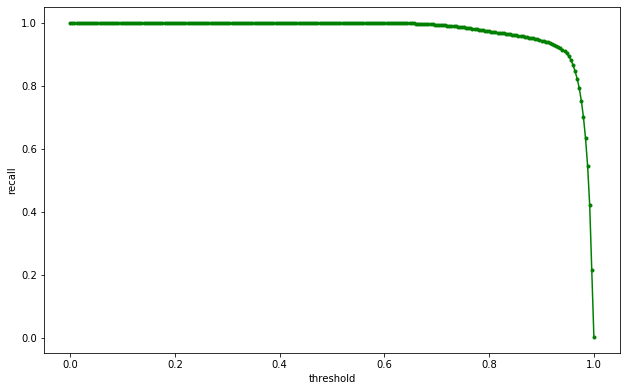

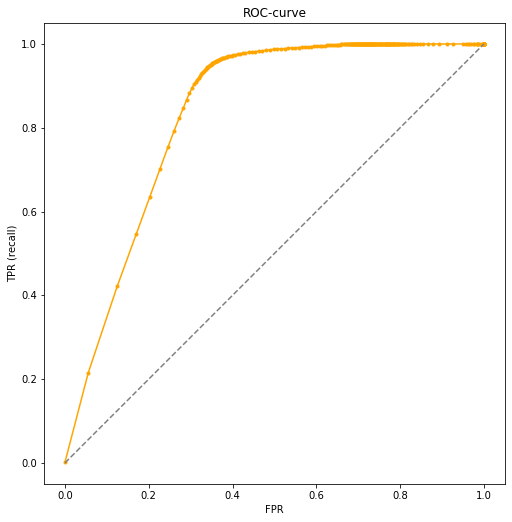

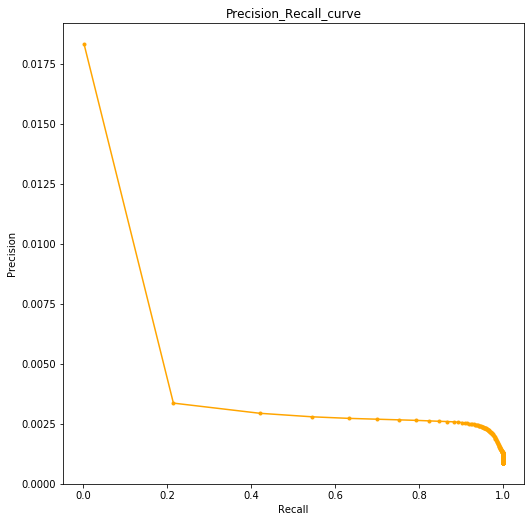

In [44]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

Done : 60100 / 60160


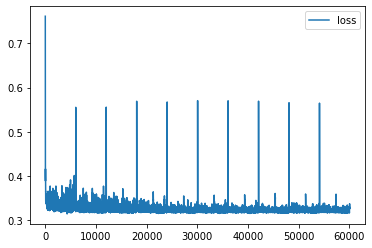


validating . . .



ROC_AUC_score = 0.8594349752271443
AVG_precision_score = 0.003502655922846609


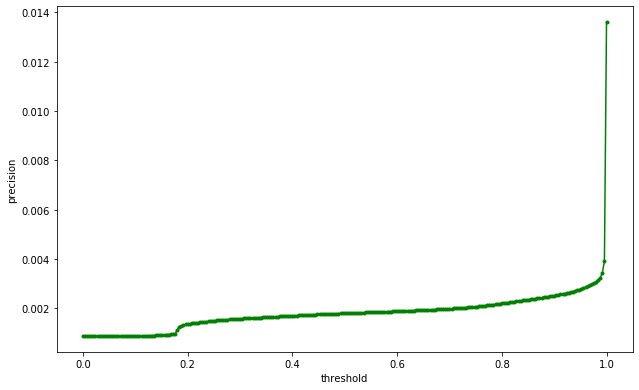

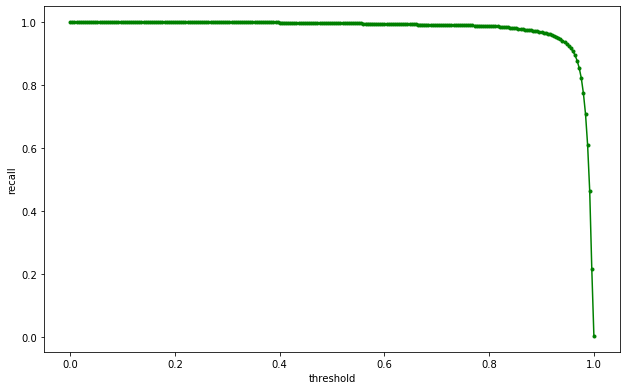

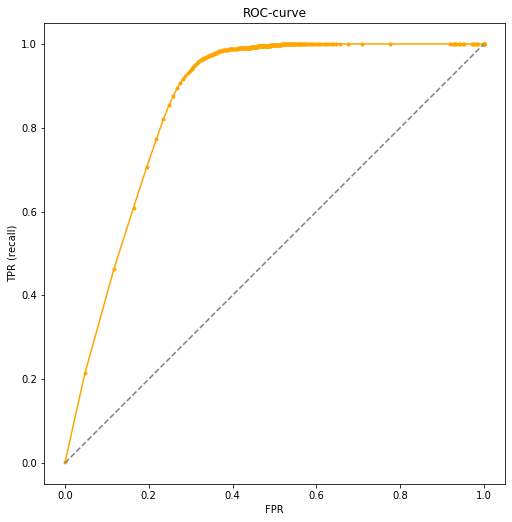

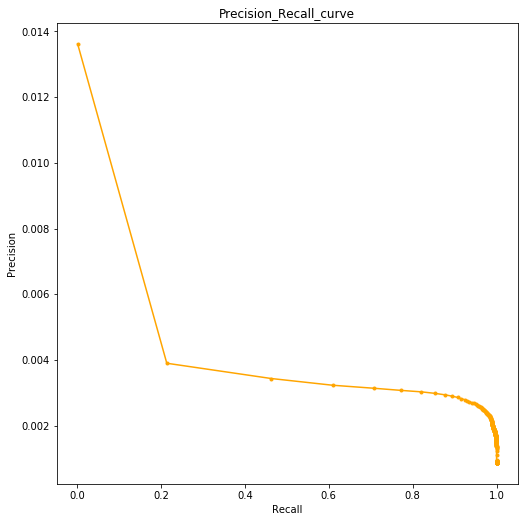

In [45]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

### эксперимент 7

исходное разбиение — 1 карта максимальной магнитуды <br>
x — каталог без афтершоков <br>
y — оригинальный аталог <br>

Done : 30000 / 30080


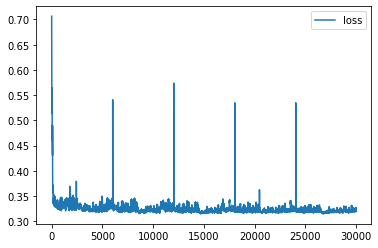


validating . . .



ROC_AUC_score = 0.8654480673265906
AVG_precision_score = 0.032305379037775465


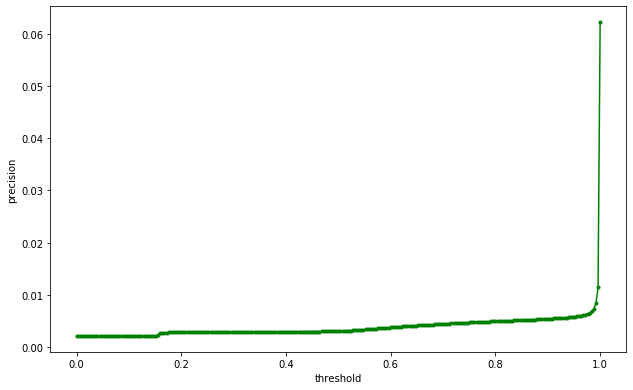

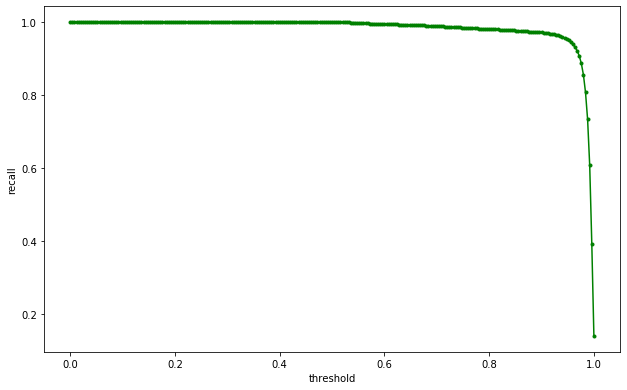

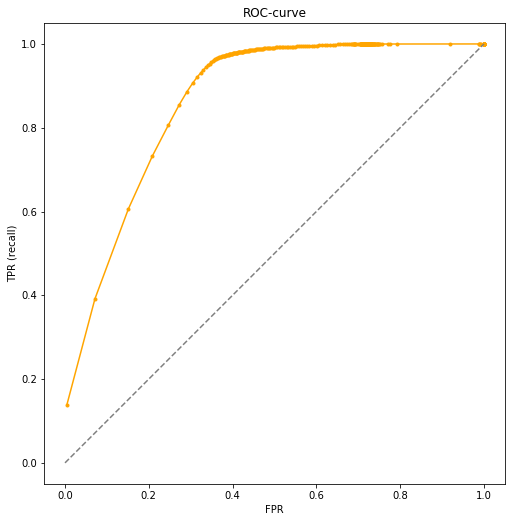

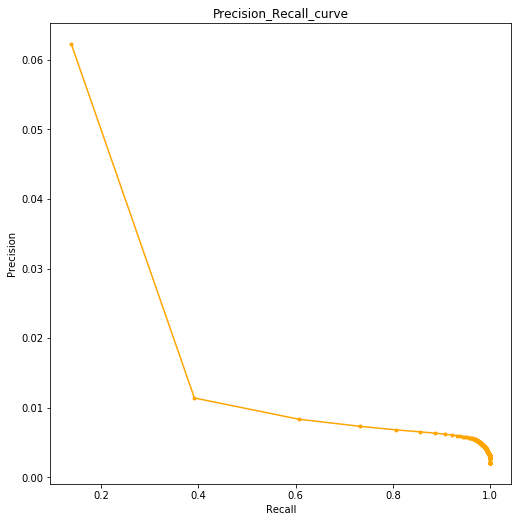

In [46]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

Done : 60100 / 60160


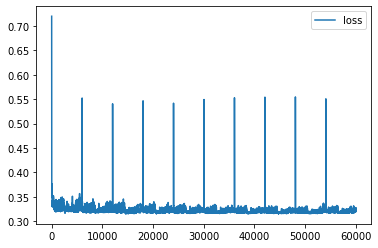


validating . . .



ROC_AUC_score = 0.864333623322056
AVG_precision_score = 0.024716287801407402


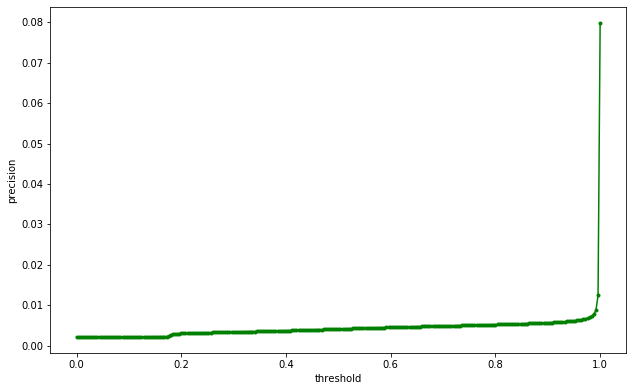

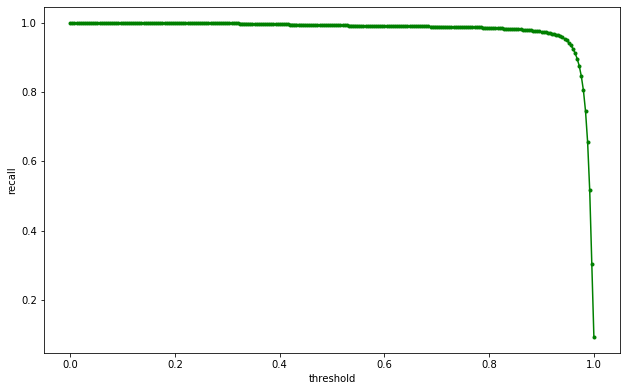

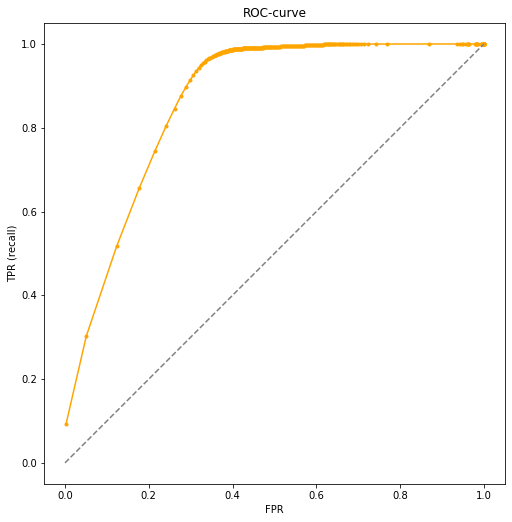

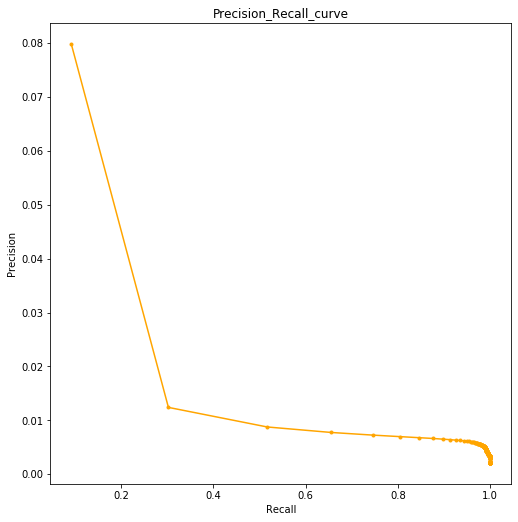

In [47]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

### эксперимент 8

исходное разбиение — 1 карта максимальной магнитуды <br>
x — каталог без афтершоков <br>
y — каталог без афтершоков <br>

Done : 30000 / 30080


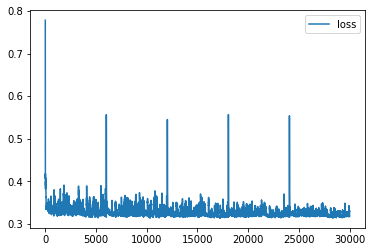


validating . . .



ROC_AUC_score = 0.852813408751478
AVG_precision_score = 0.004577229801138168


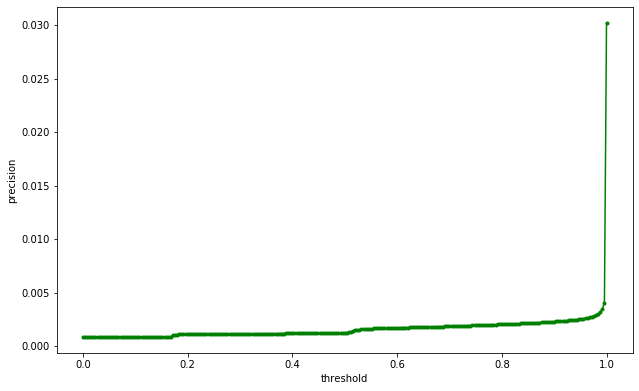

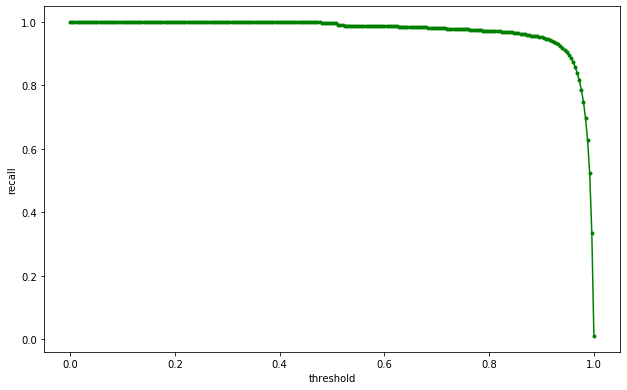

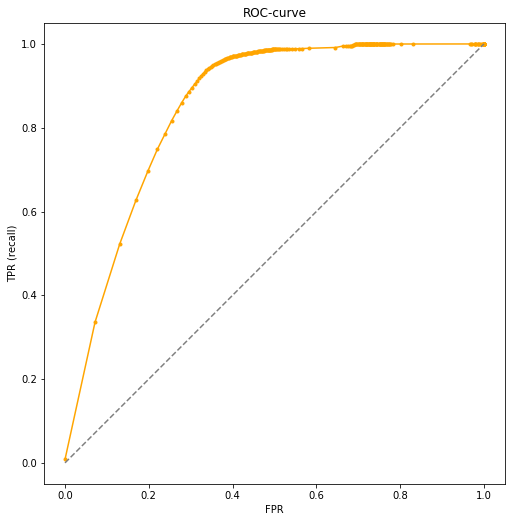

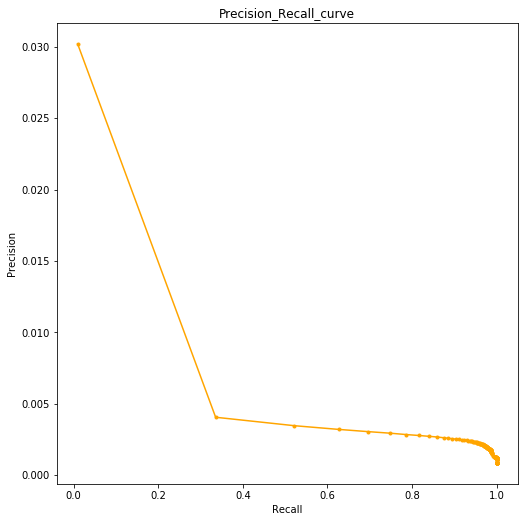

In [48]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

Done : 60100 / 60160


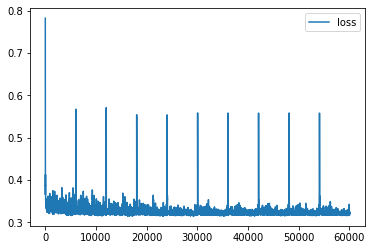


validating . . .



ROC_AUC_score = 0.8566732971117833
AVG_precision_score = 0.0036891646885130152


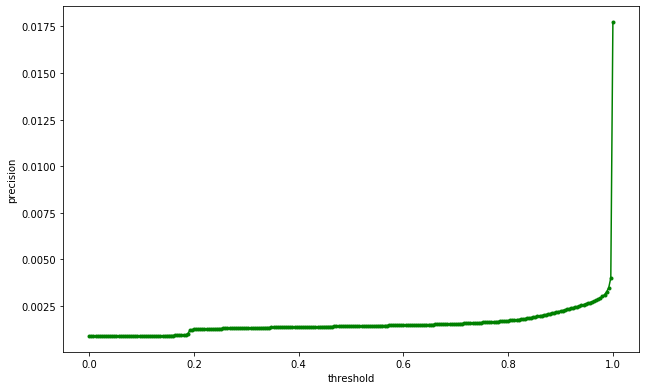

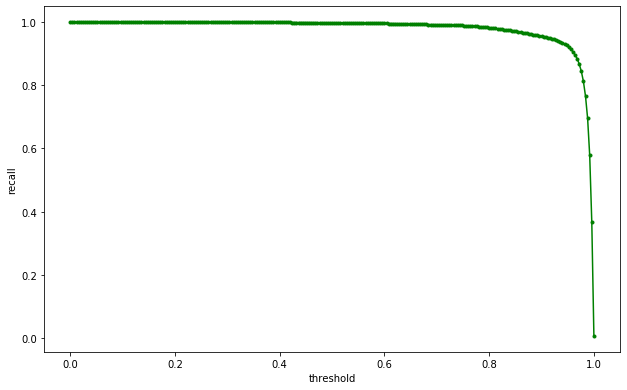

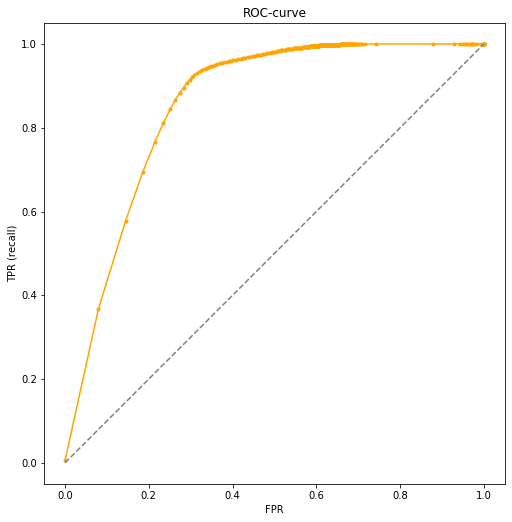

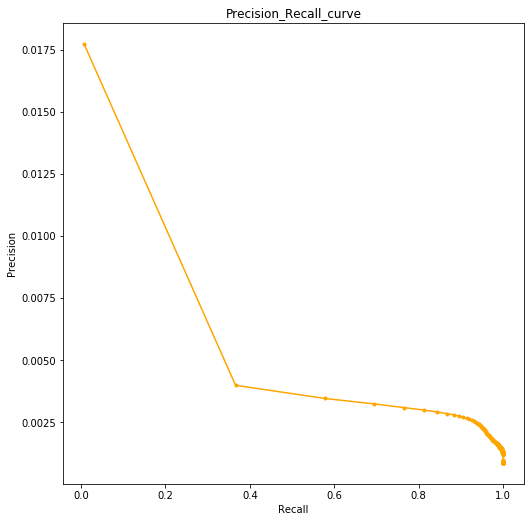

In [49]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-3
LR_DECAY = 2.
START_LR_DECAY = 10
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 100

pipe = pipeline(
                                        celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                                        model_name = MODEL_MAXMAGN_Xorig_Yorig,
                                        n_cells_hor = N_CELLS_HOR, 
                                        n_cells_ver = N_CELLS_VER,
                                        testing_days = TESTING_DAYS,
                                        heavy_quake_thres = HEAVY_QUAKE_THRES,
                                        days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                                        days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                                        embedding_size = EMB_SIZE,
                                        hidden_state_size = HID_SIZE,
                                        n_cycles = N_CYCLES,
                                        learning_rate = LEARNING_RATE,
                                        earthquake_weight = EARTHQUAKE_WEIGHT,
                                        lr_decay = LR_DECAY,
                                        start_lr_decay = START_LR_DECAY,
                                        weight_decay = WEIGHT_DECAY,
                                        device = device,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS
                                     )

pipe()

| data | X | Y | ROC_AUC | AVG_precision |
| --- | --- | --- | --- | --- |
| <b> max magnitude map | <b> orig | <b> orig | <b> 0.912 | <b> 0.066 |
| max magnitude map | orig | without aft | 0.859 | 0.004 |
| max magnitude map | without aft | orig | 0.865 | 0.032 |
| max magnitude map | without aft | without aft | 0.857 | 0.004 |

## разбиение с картой плотности и максимальной магнитудой

### эксперимент 9

исходное разбиение: 1 карта — магнитуды, 2 — плотности <br>
x — оригинальный каталог <br>
y — оригинальный каталог <br>

Done : 30000 / 30080


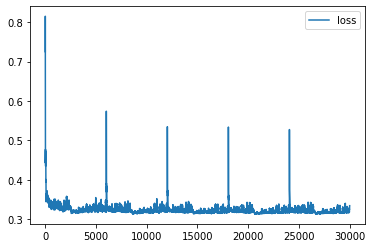


validating . . .



ROC_AUC_score = 0.9068585109338254
AVG_precision_score = 0.06430096443031709


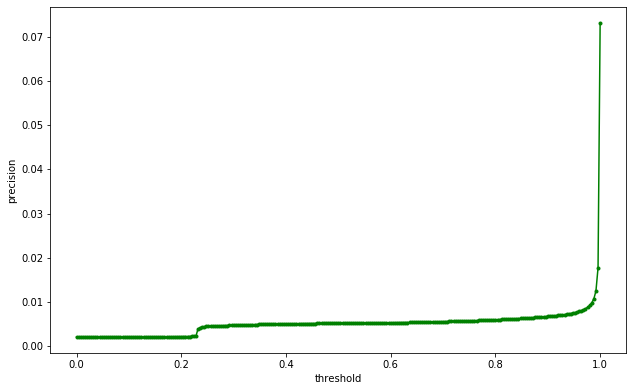

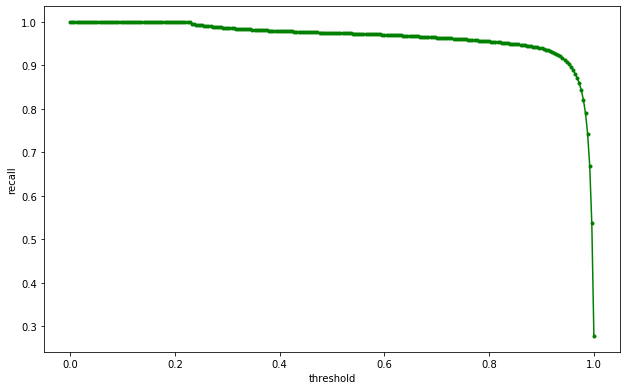

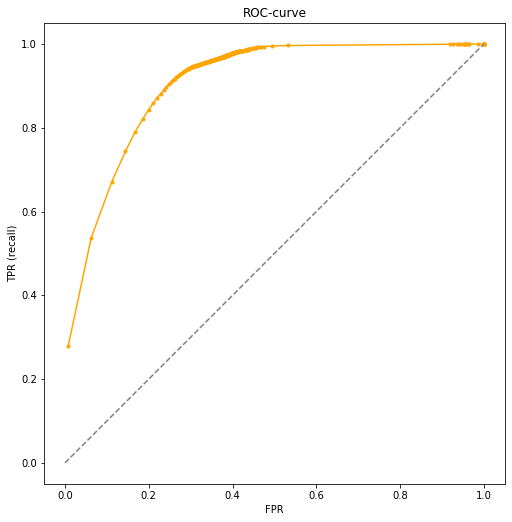

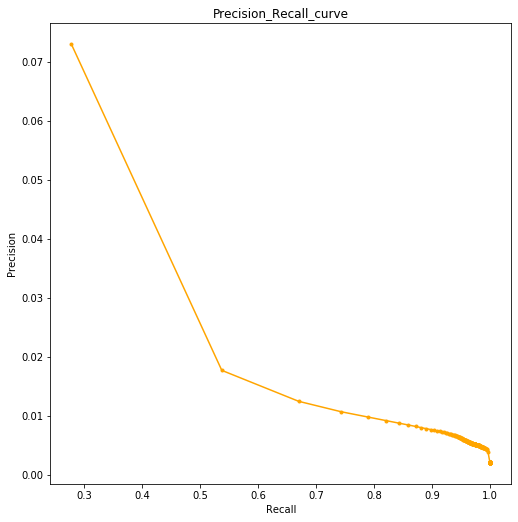

In [50]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Yorig,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


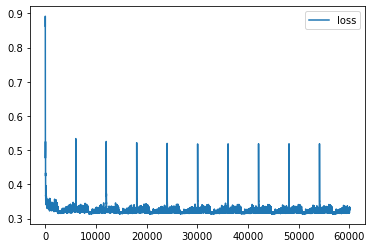


validating . . .



ROC_AUC_score = 0.9079994283574339
AVG_precision_score = 0.06520732178915015


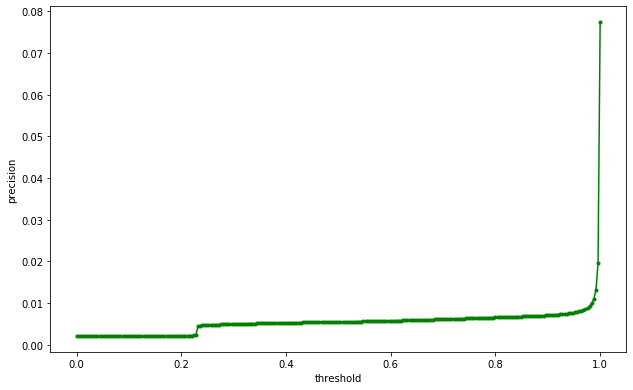

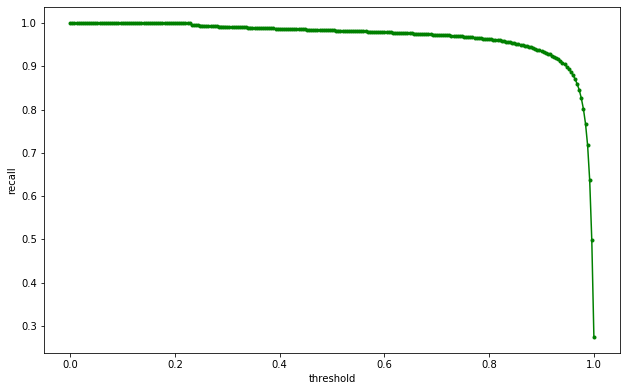

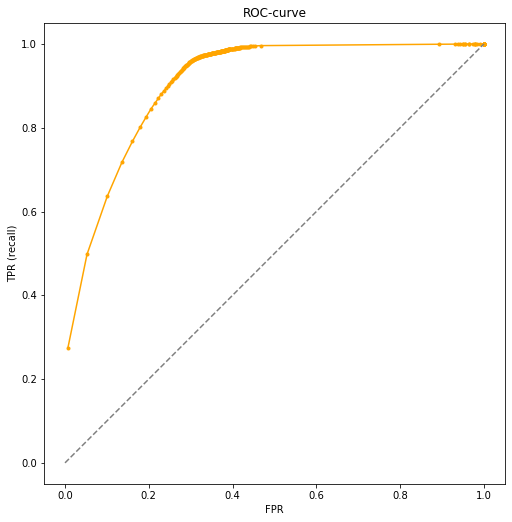

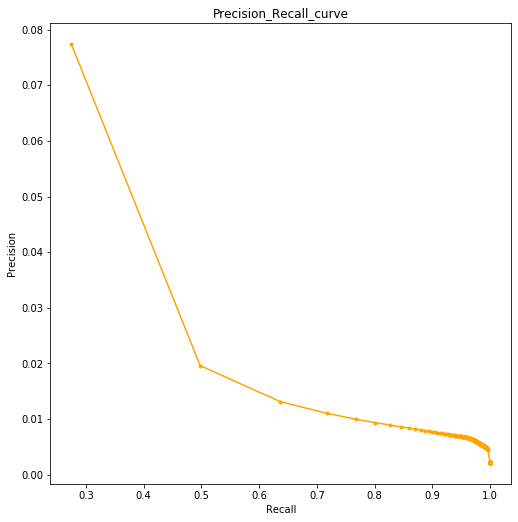

In [51]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Yorig,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 10

исходное разбиение: 1 карта — магнитуды, 2 — плотности <br>
x — оригинальный каталог <br>
y — каталог без афтершоков <br>

Done : 30000 / 30080


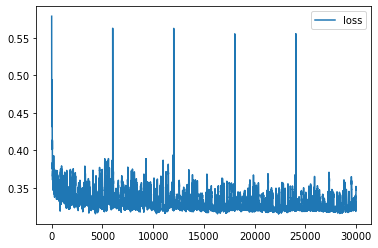


validating . . .



ROC_AUC_score = 0.8341800927037099
AVG_precision_score = 0.0029157350940843545


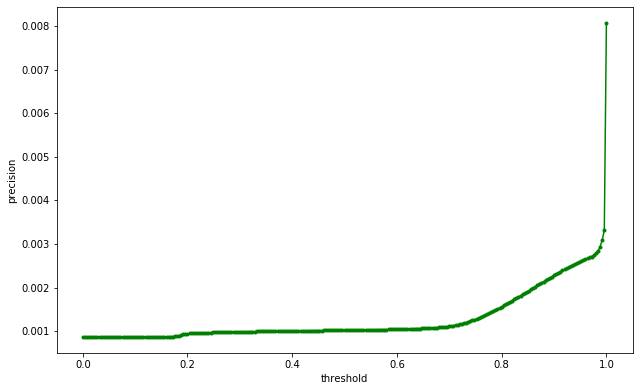

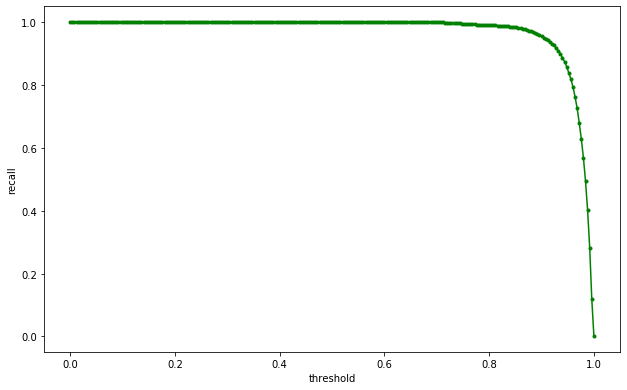

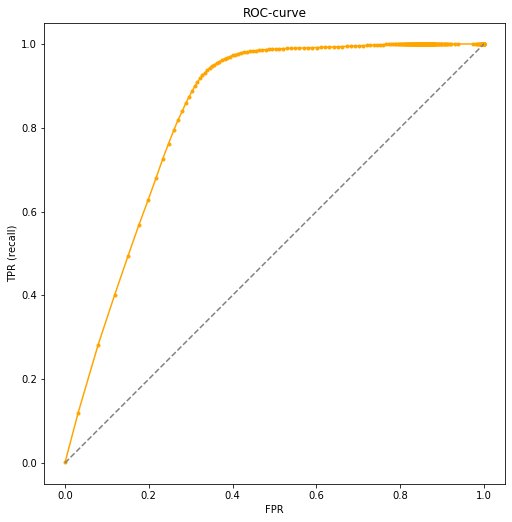

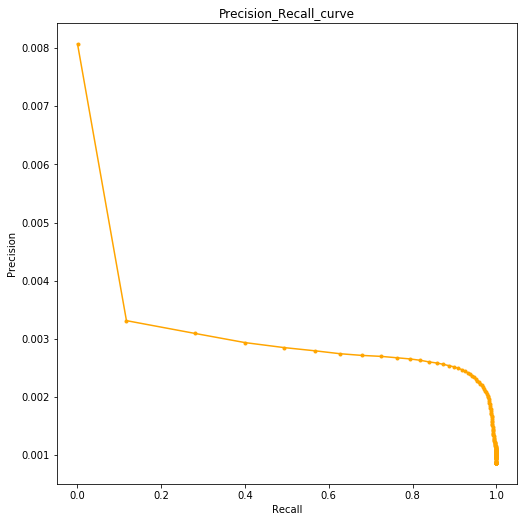

In [52]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


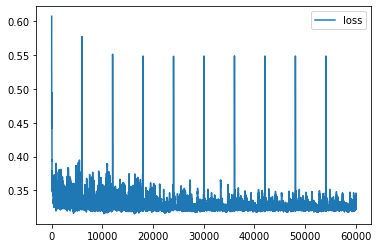


validating . . .



ROC_AUC_score = 0.8217247515019527
AVG_precision_score = 0.0027560158641395244


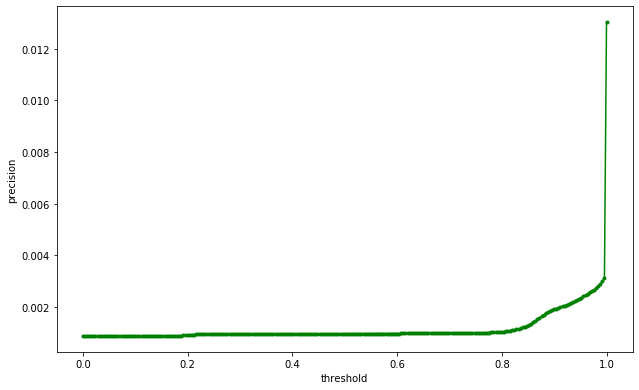

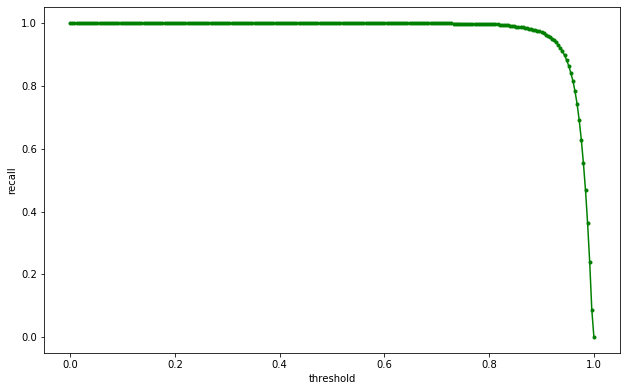

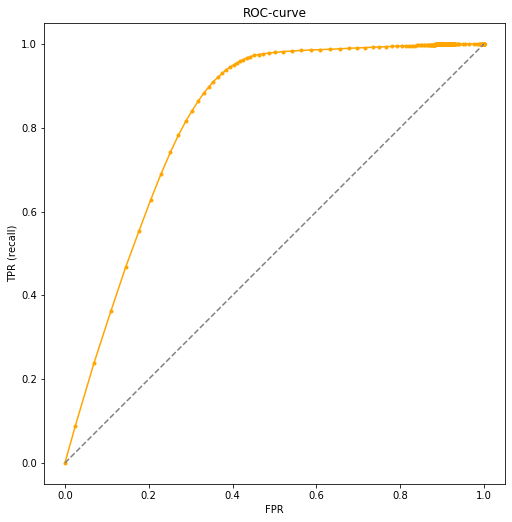

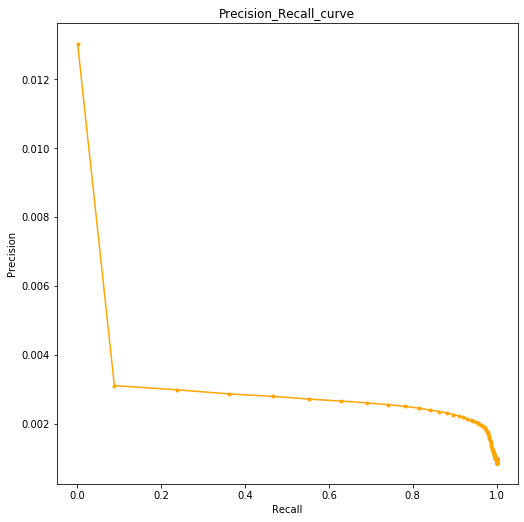

In [53]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 11

исходное разбиение: 1 карта — магнитуды, 2 — плотности <br>
x — каталог без афтершоков <br>
y — оригинальный каталог <br>

Done : 30000 / 30080


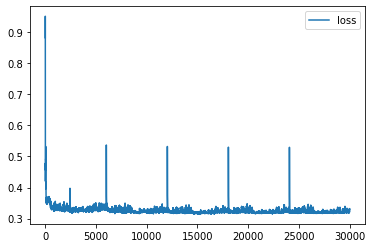


validating . . .



ROC_AUC_score = 0.8546069141346793
AVG_precision_score = 0.021206951469056372


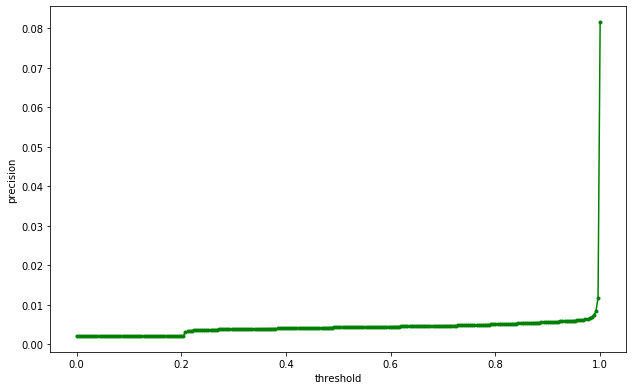

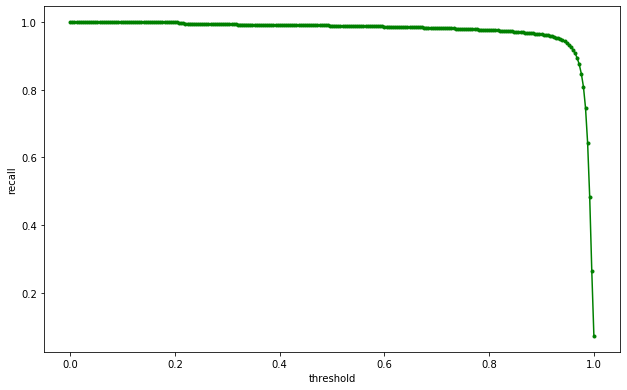

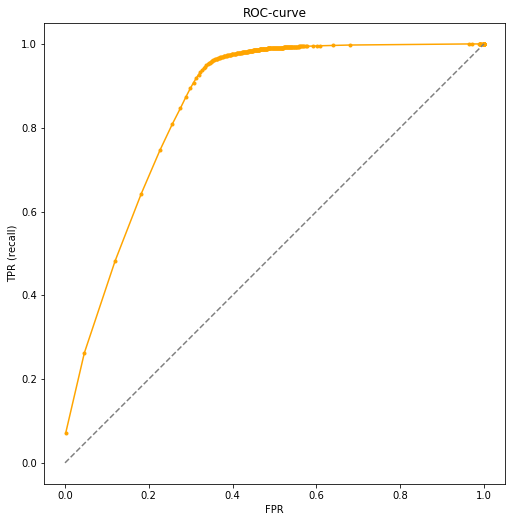

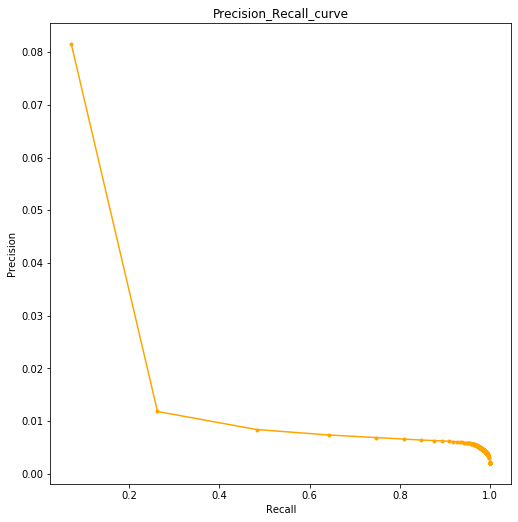

In [54]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


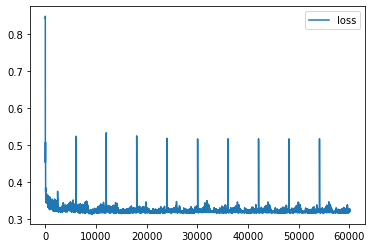


validating . . .



ROC_AUC_score = 0.851788798586739
AVG_precision_score = 0.025112557287330035


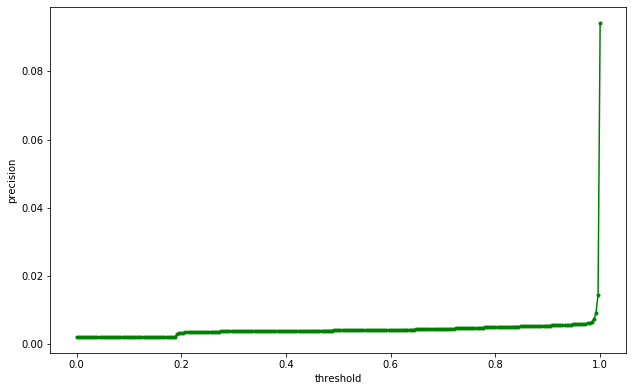

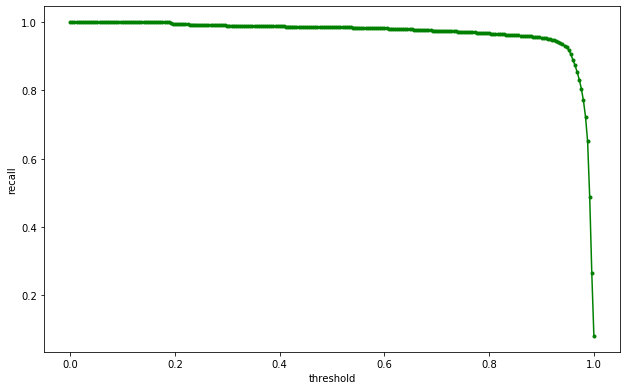

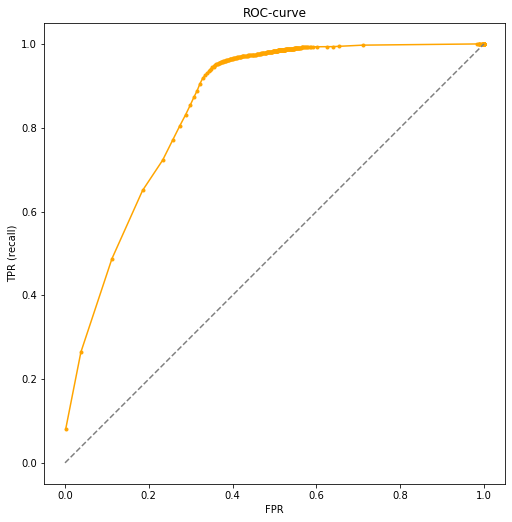

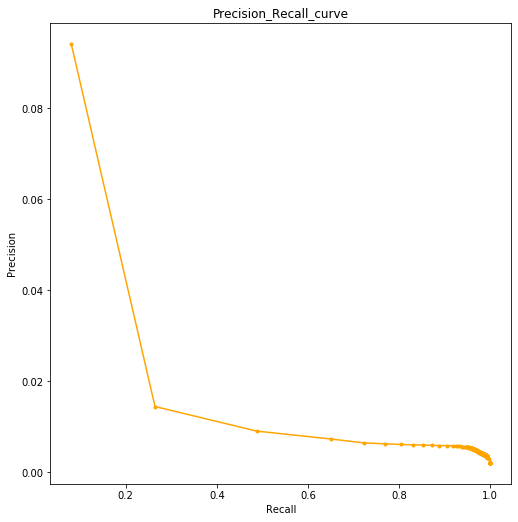

In [55]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 12

исходное разбиение: 1 карта — магнитуды, 2 — плотности <br>
x — каталог без афтершоков <br>
y — каталог без афтершоков <br>

Done : 30000 / 30080


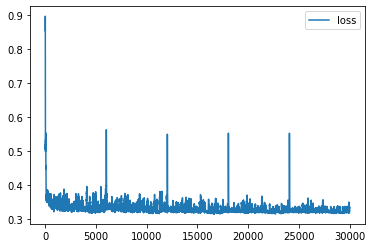


validating . . .



ROC_AUC_score = 0.8542258544200791
AVG_precision_score = 0.004062897377364672


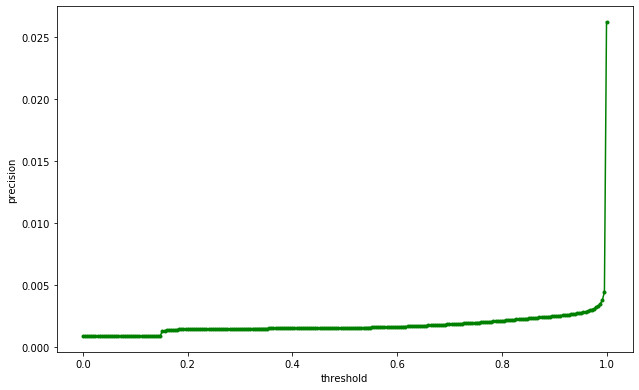

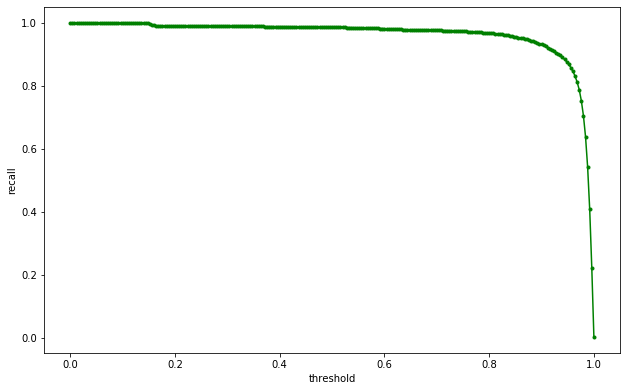

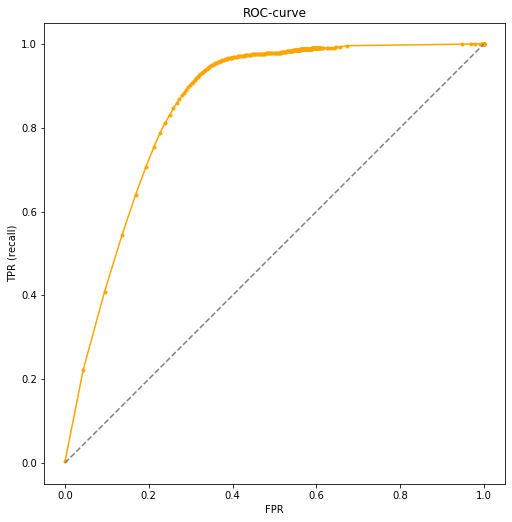

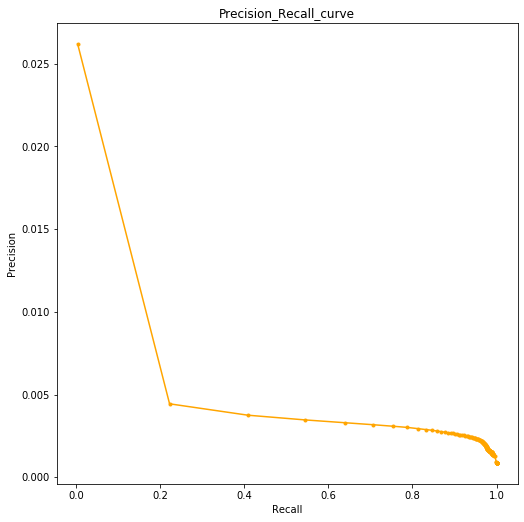

In [56]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xwithoutaft_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


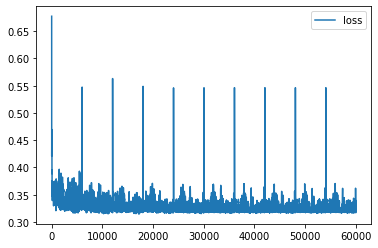


validating . . .



ROC_AUC_score = 0.8278698098861228
AVG_precision_score = 0.003953118385168004


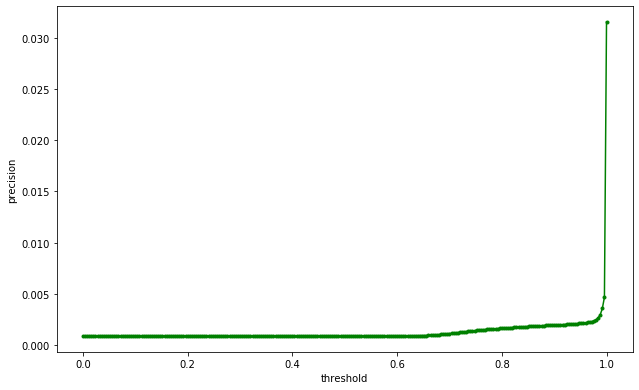

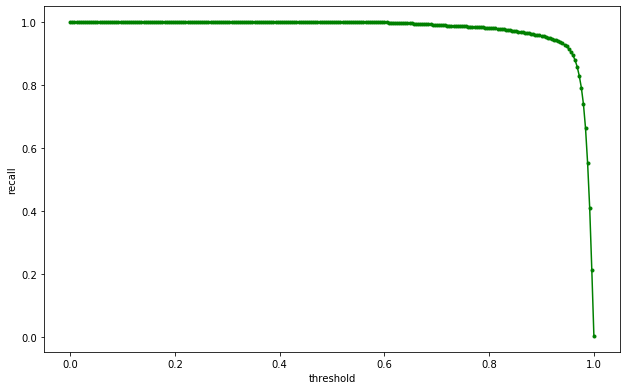

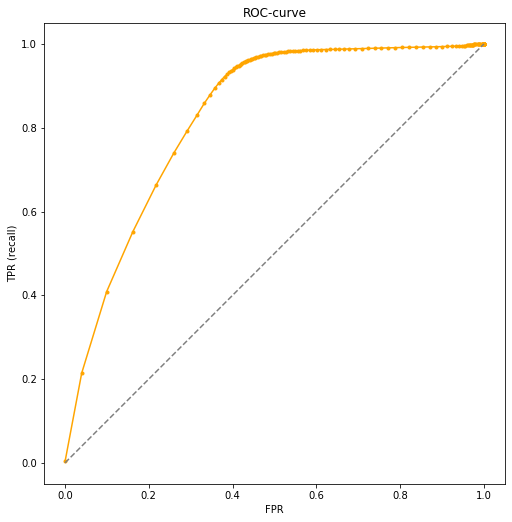

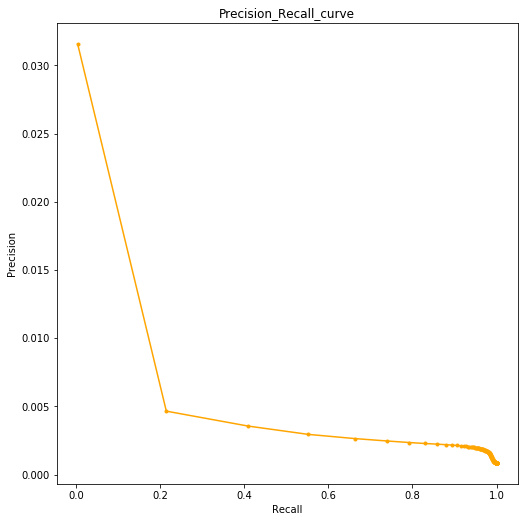

In [57]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 1e-2
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xwithoutaft_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

In [ ]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 100
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xwithoutaft_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

## исходное разбиение с картой плотности

### эксперимент 13
X — оригинальный, Y — оригинальный

Done : 30000 / 30080


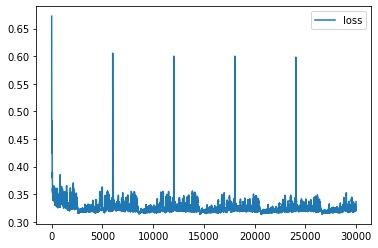


validating . . .



ROC_AUC_score = 0.8887936343432651
AVG_precision_score = 0.02331235009275743


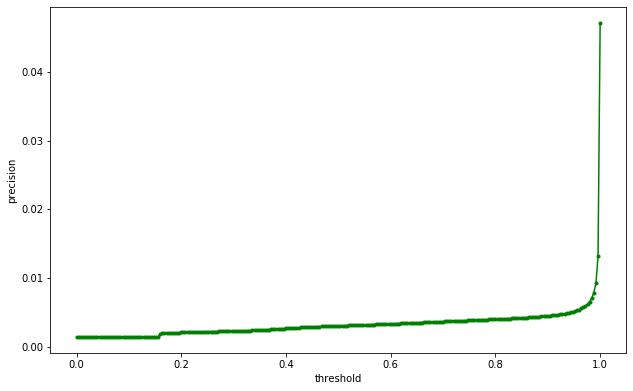

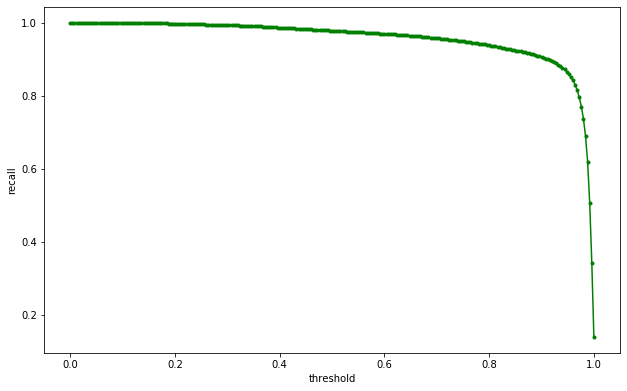

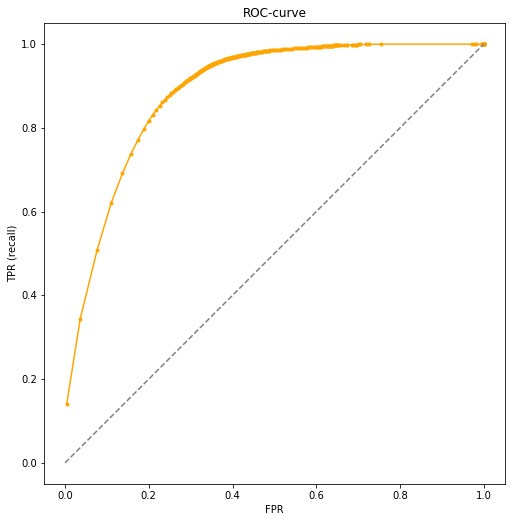

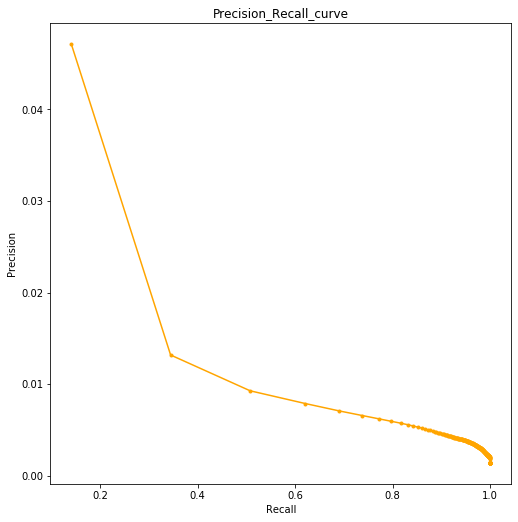

In [28]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


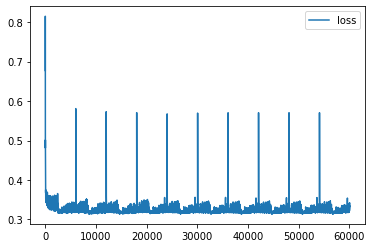


validating . . .



ROC_AUC_score = 0.8904160426839791
AVG_precision_score = 0.021367119020517078


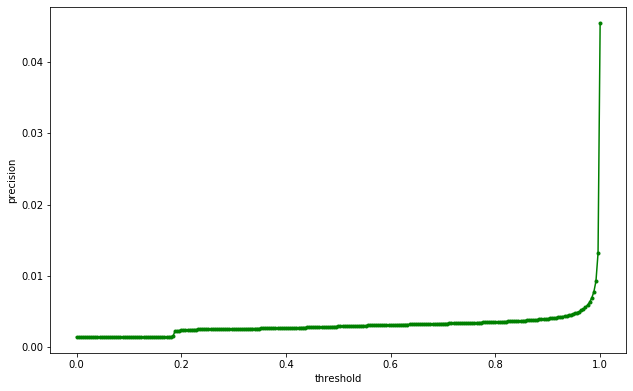

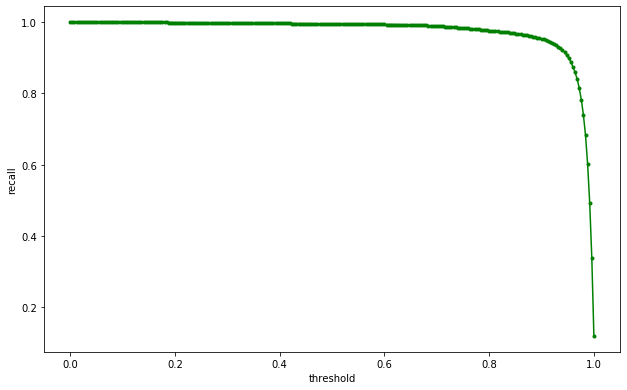

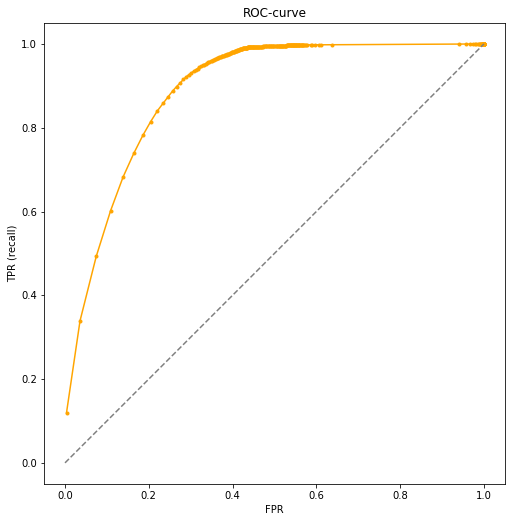

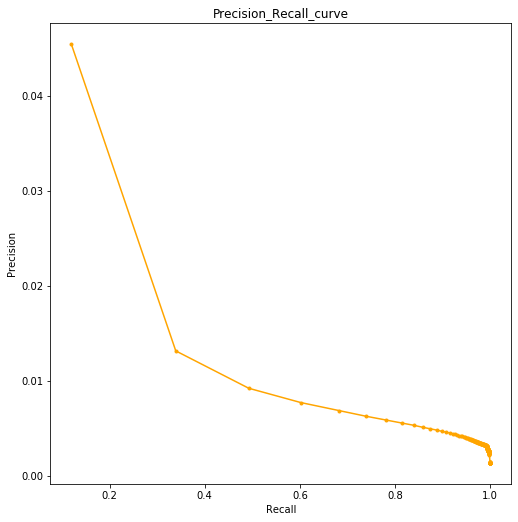

In [58]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 30000 / 30080


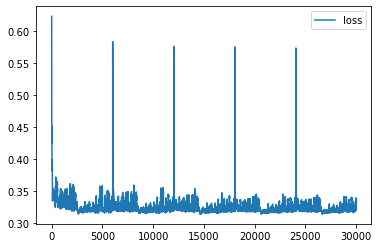


validating . . .



ROC_AUC_score = 0.8698668184835409
AVG_precision_score = 0.02303441826081736


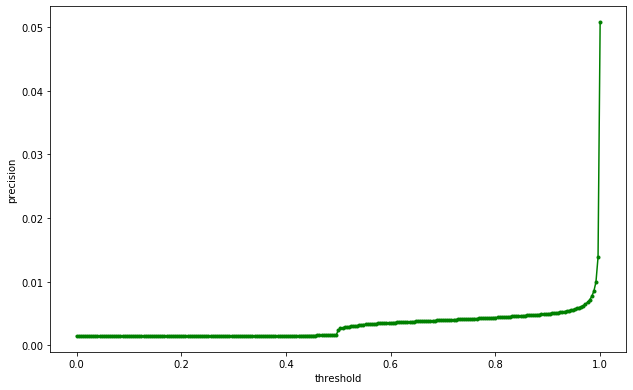

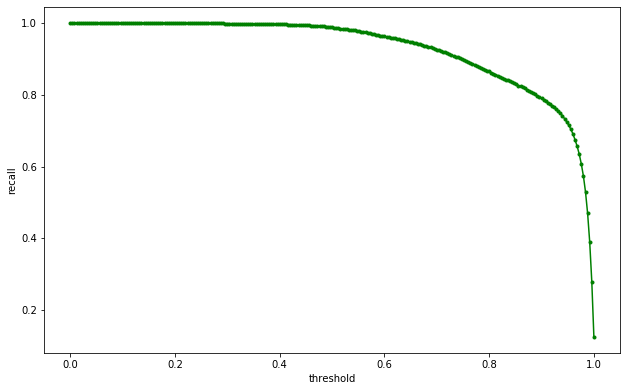

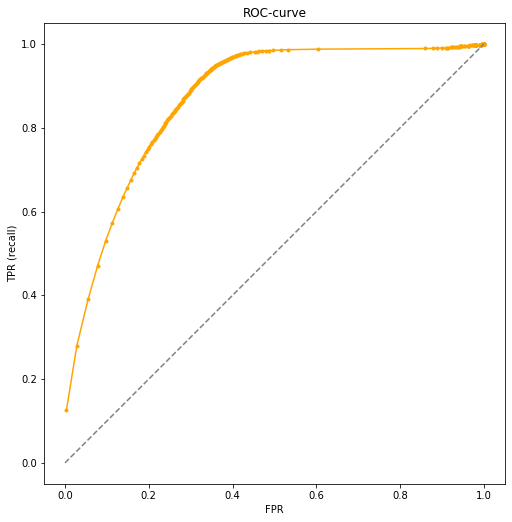

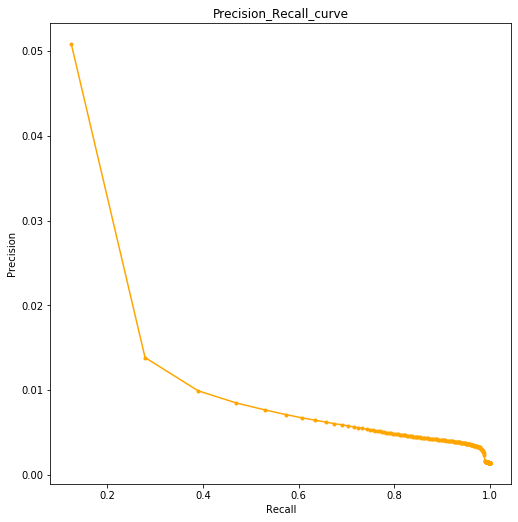

In [59]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


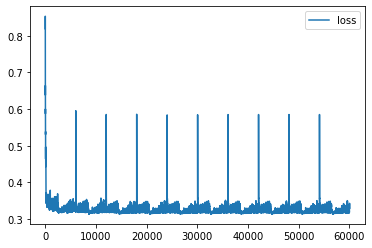


validating . . .



ROC_AUC_score = 0.876429490354761
AVG_precision_score = 0.022134340539056767


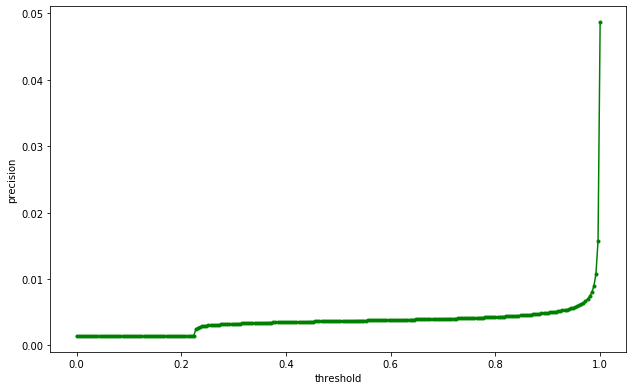

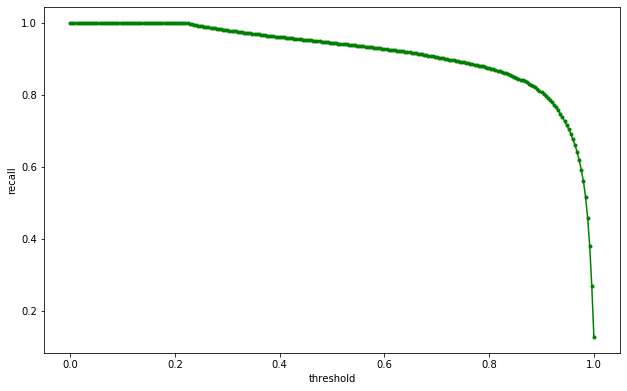

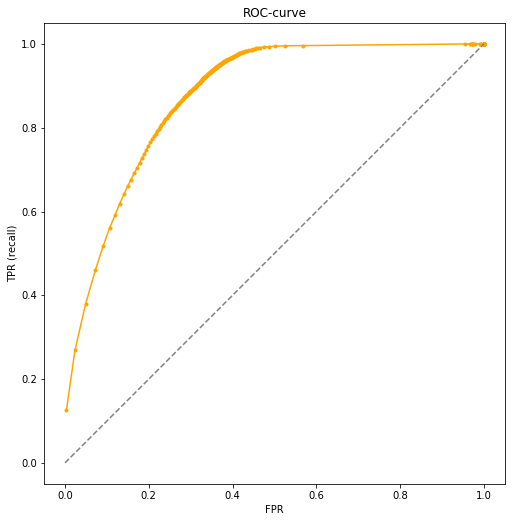

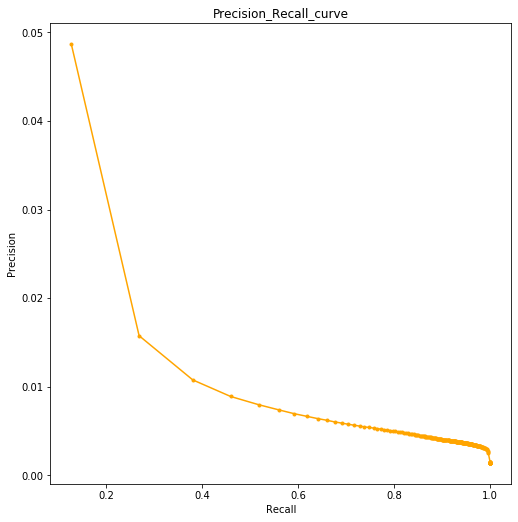

In [60]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 14
X — оригинальный, Y — без афтершоков

Done : 30000 / 30080


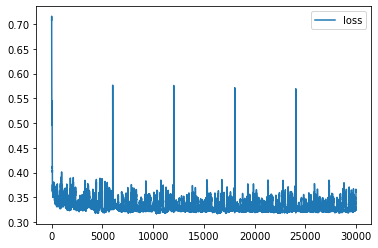


validating . . .



ROC_AUC_score = 0.844074642649891
AVG_precision_score = 0.002780072633632531


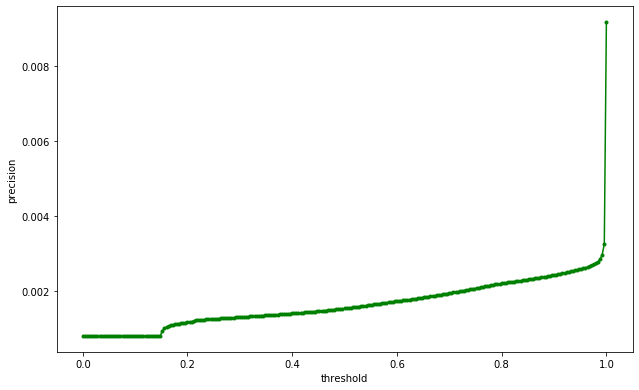

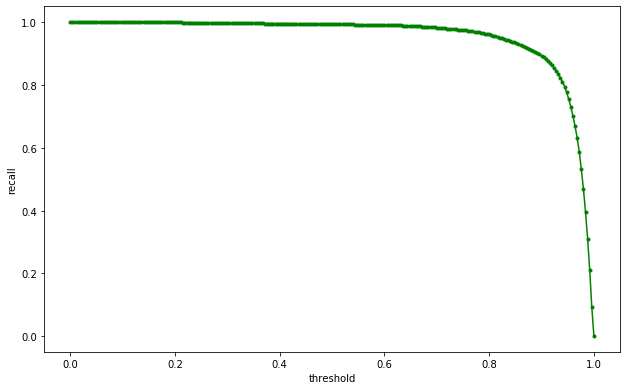

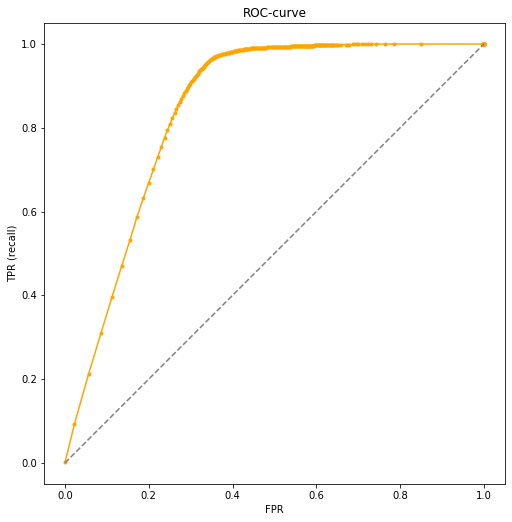

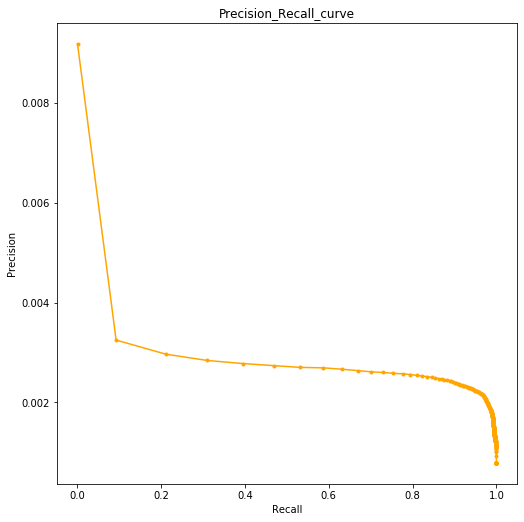

In [29]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


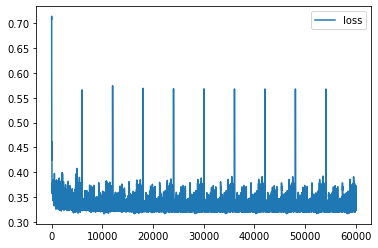


validating . . .



ROC_AUC_score = 0.8300713517367923
AVG_precision_score = 0.0025344226404277856


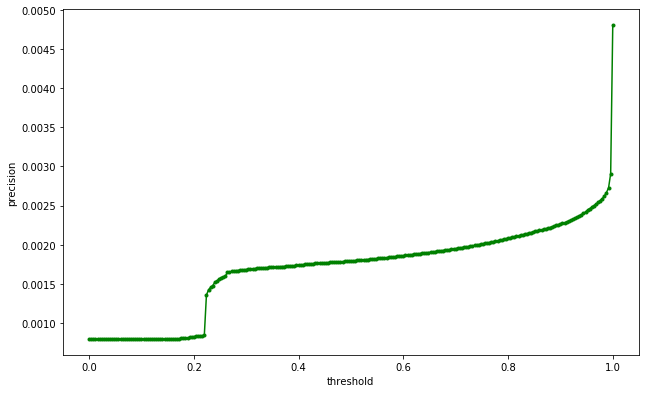

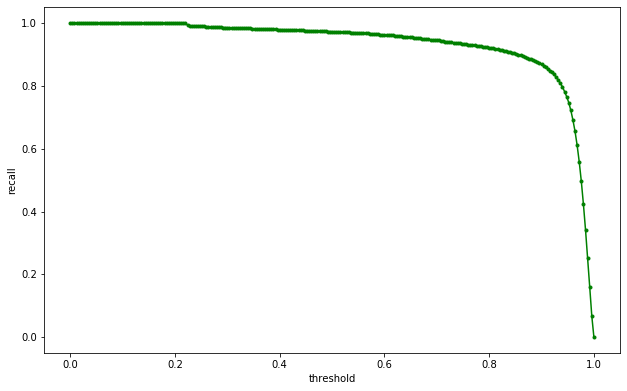

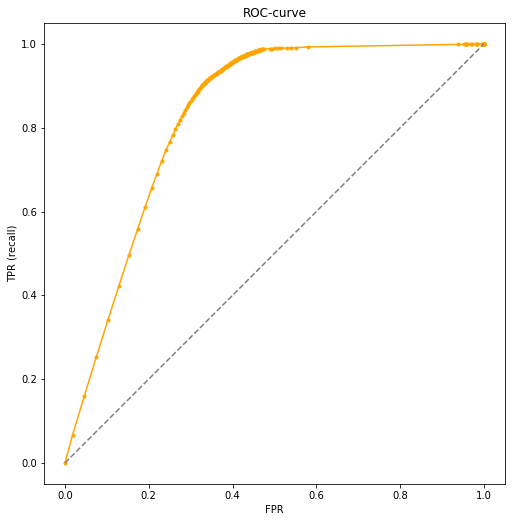

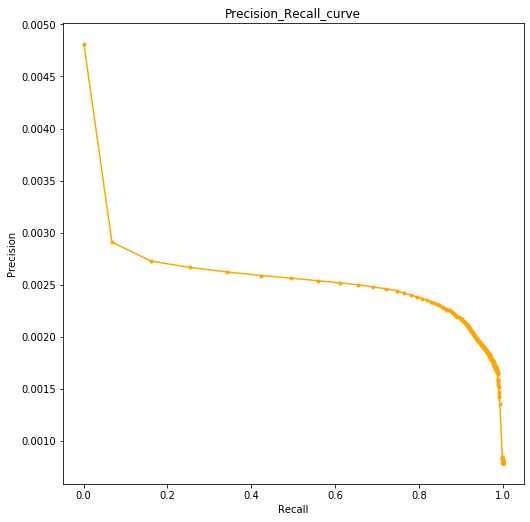

In [61]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 30000 / 30080


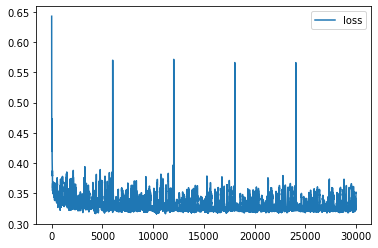


validating . . .



ROC_AUC_score = 0.8503711755867424
AVG_precision_score = 0.002830941431401679


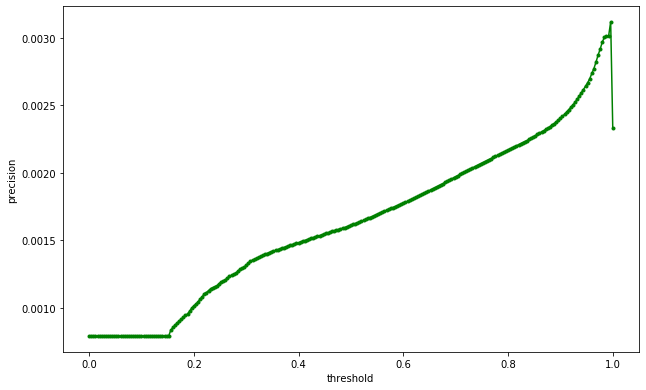

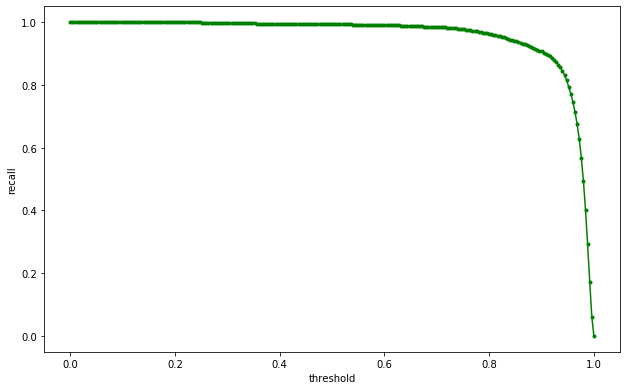

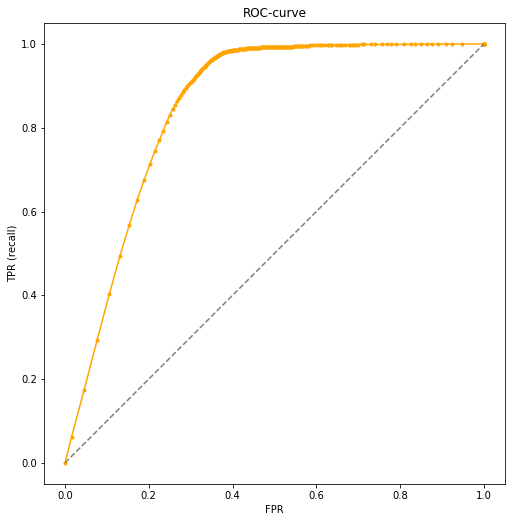

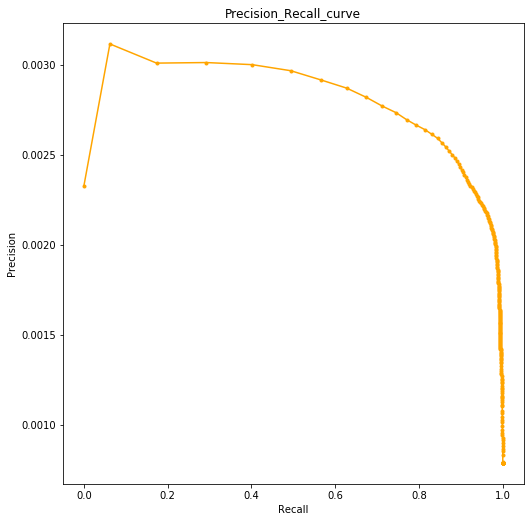

In [62]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


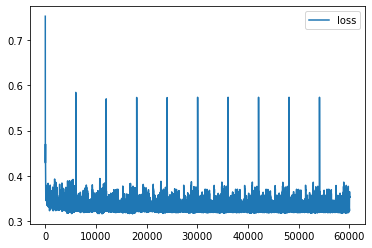


validating . . .



ROC_AUC_score = 0.8295832237651698
AVG_precision_score = 0.0025450161718067305


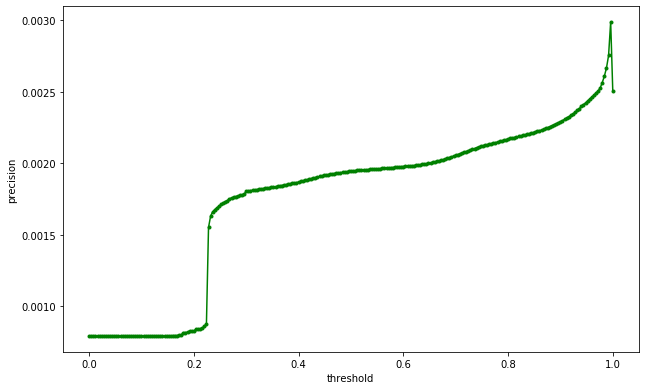

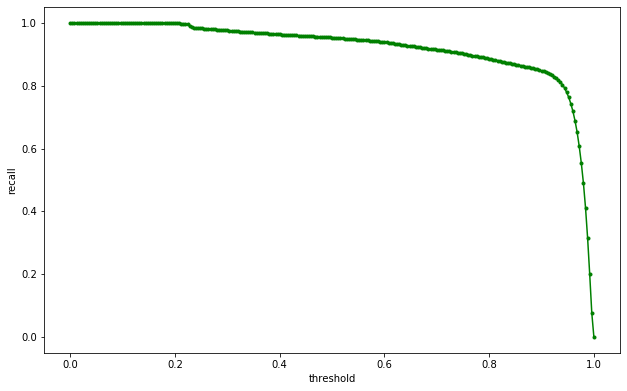

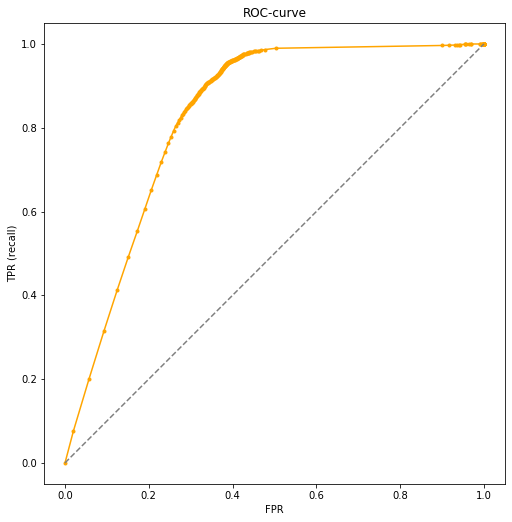

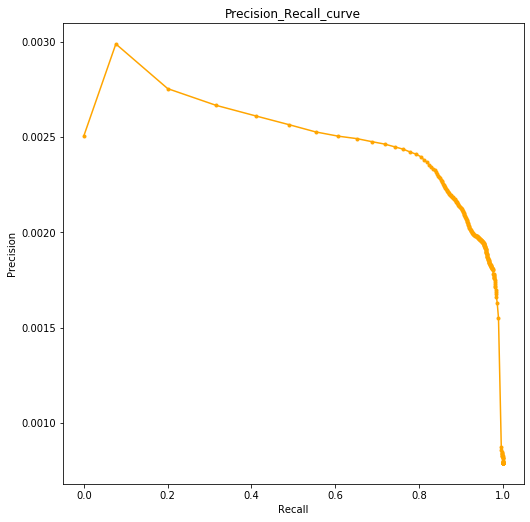

In [63]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 14
X — без афтершоков, Y — оригинальный

Done : 30000 / 30080


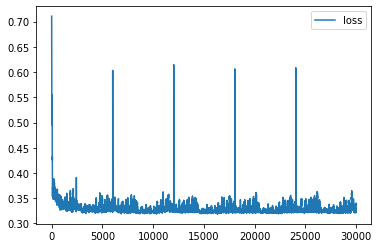


validating . . .



ROC_AUC_score = 0.8447254120250348
AVG_precision_score = 0.010003305592102834


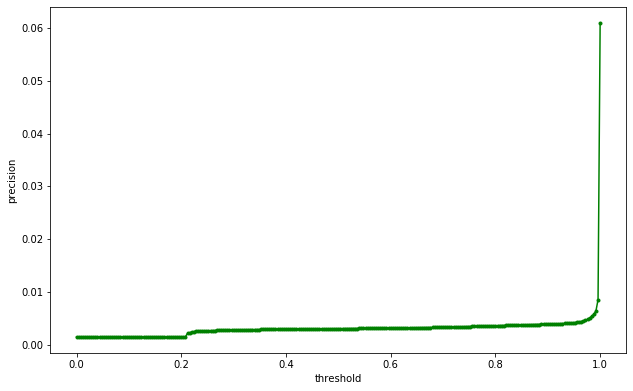

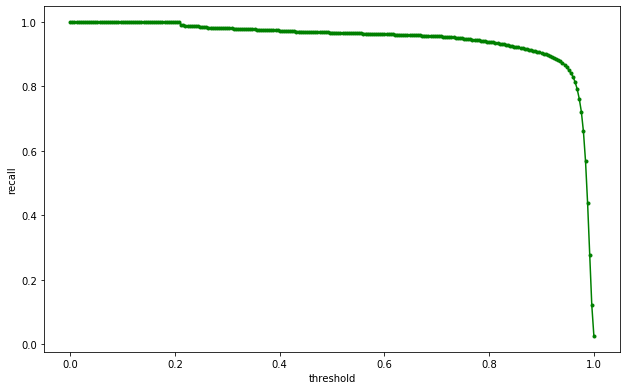

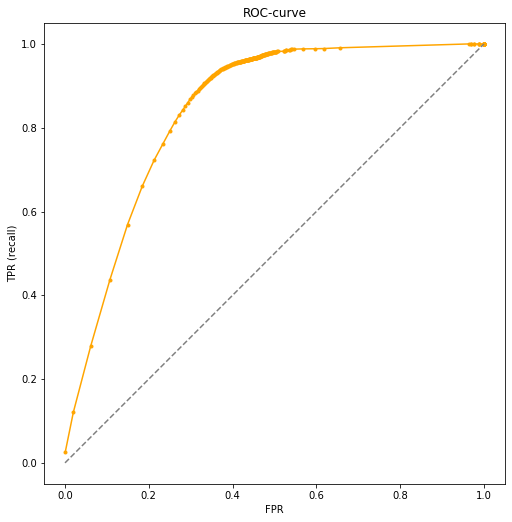

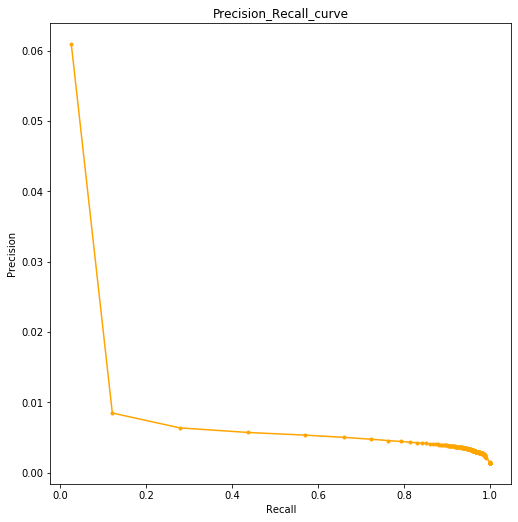

In [30]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


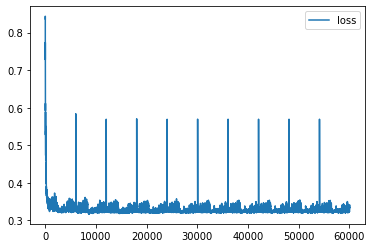


validating . . .



ROC_AUC_score = 0.840205794922627
AVG_precision_score = 0.008147248880557869


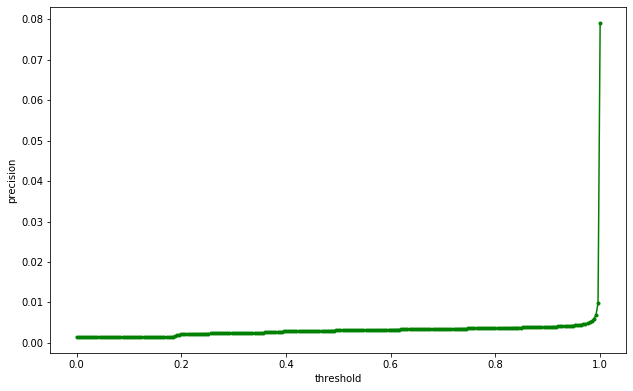

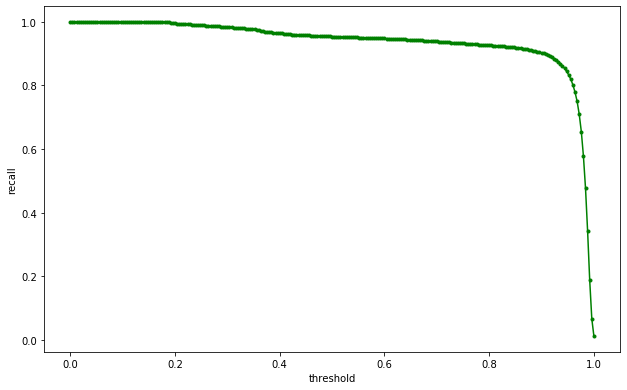

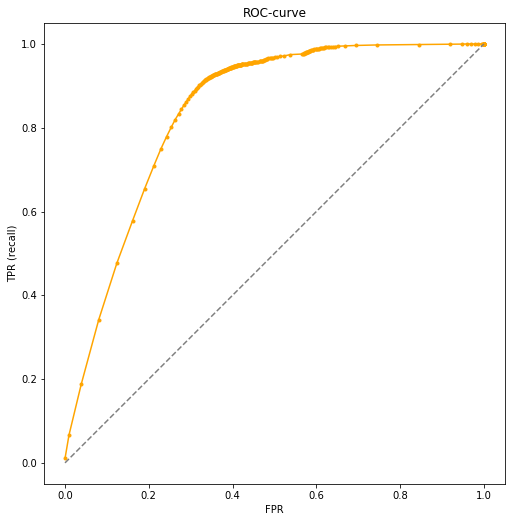

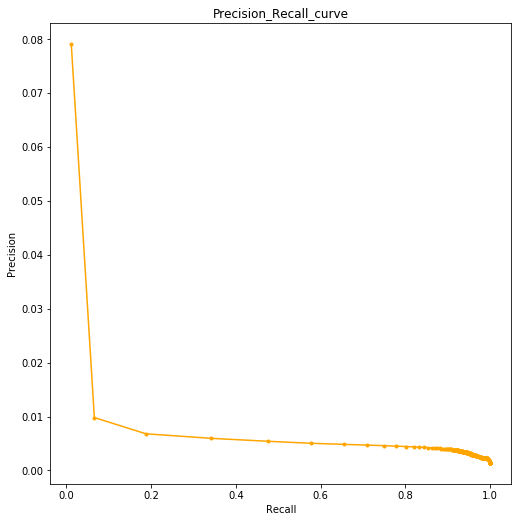

In [31]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 30000 / 30080


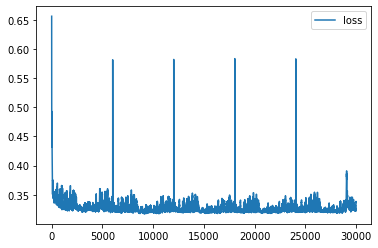


validating . . .



ROC_AUC_score = 0.8330043162302749
AVG_precision_score = 0.008189677748808737


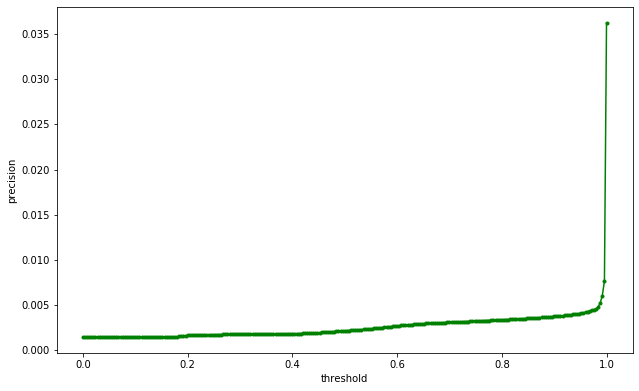

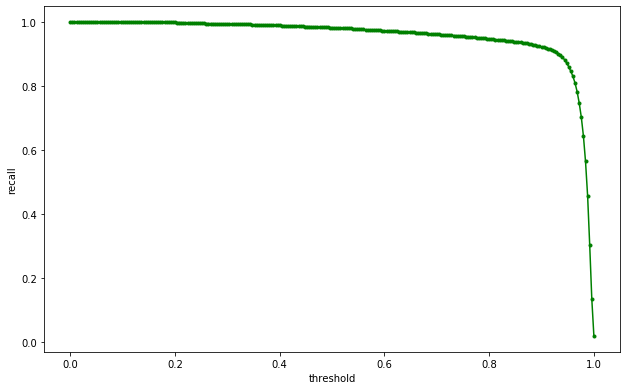

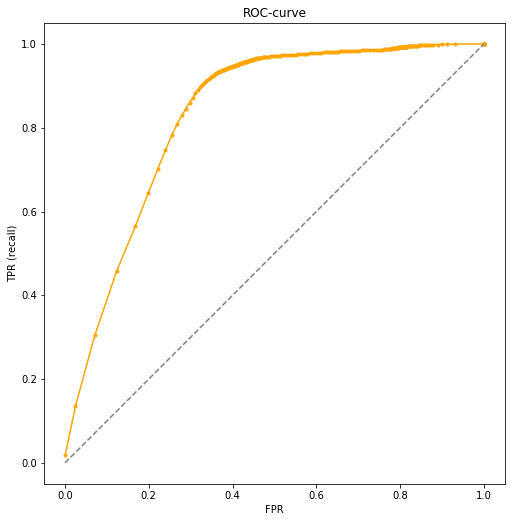

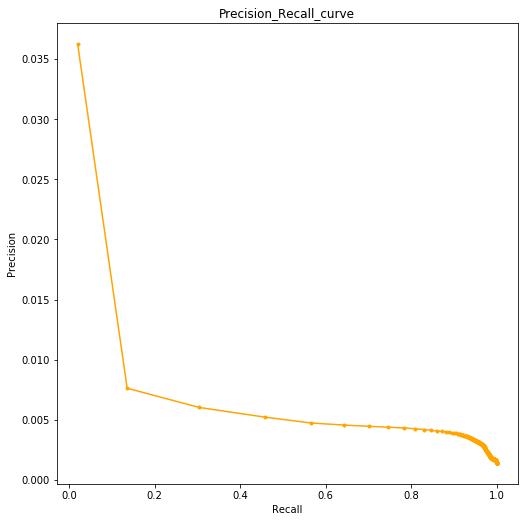

In [64]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


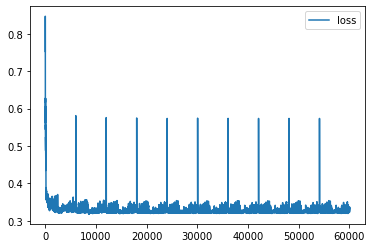


validating . . .



ROC_AUC_score = 0.6698350530714304
AVG_precision_score = 0.003702763252748439


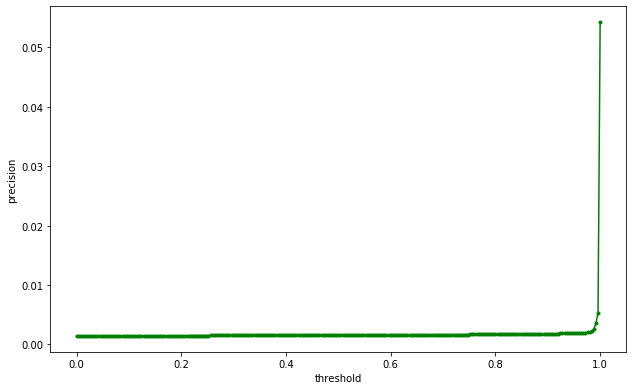

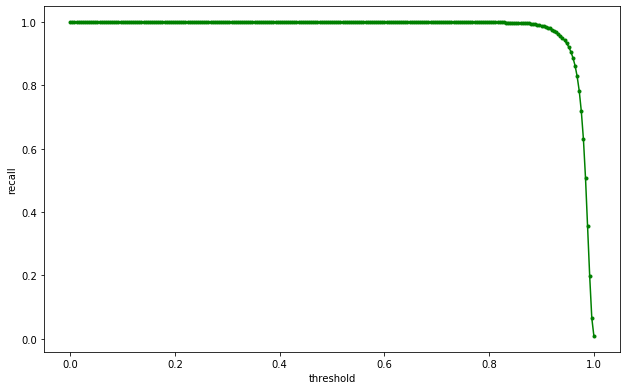

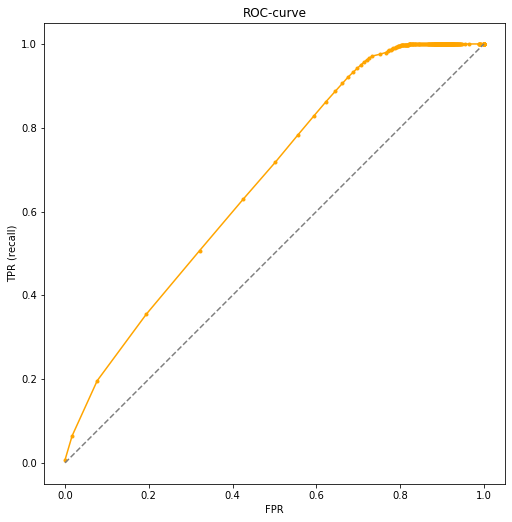

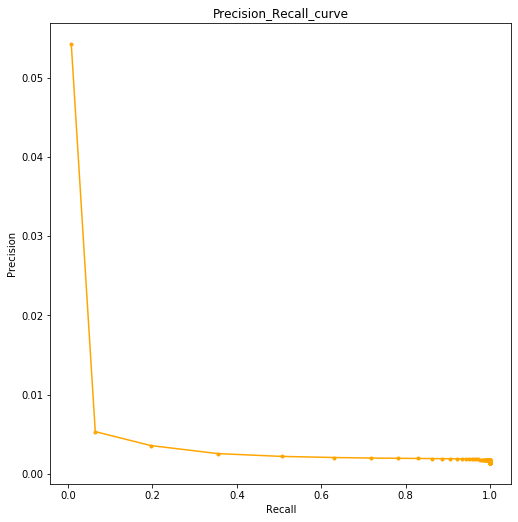

In [65]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_CAT_ORIG_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_CAT_ORIG_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

### эксперимент 15
X — без афтершоков, Y — без афтершоков

Done : 30000 / 30080


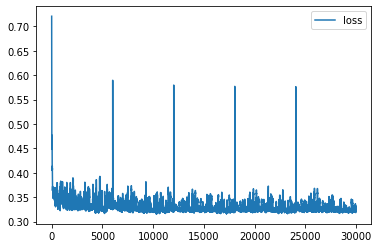


validating . . .



ROC_AUC_score = 0.8563427062992629
AVG_precision_score = 0.0035683341882481847


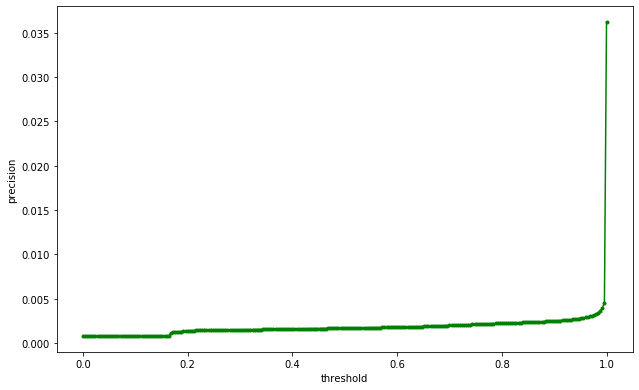

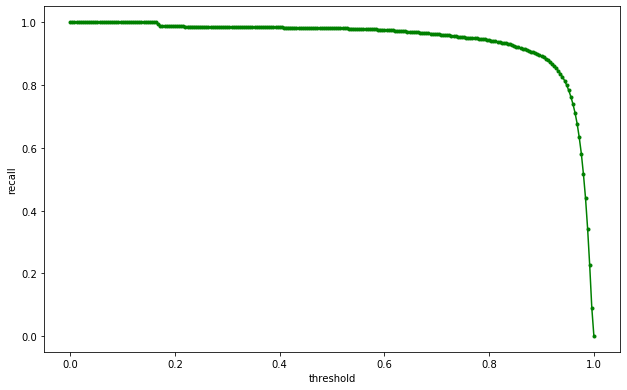

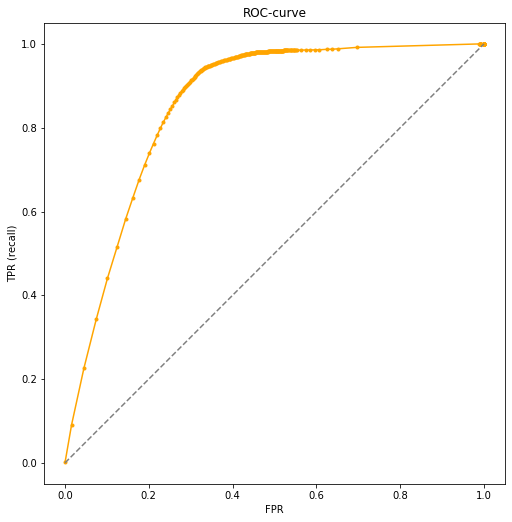

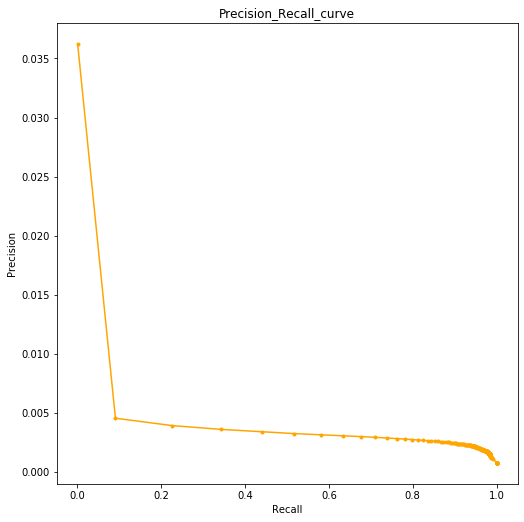

In [32]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


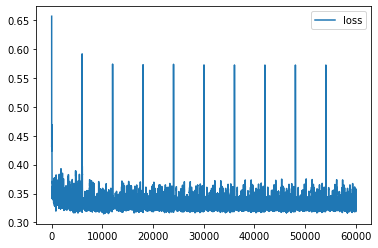


validating . . .



ROC_AUC_score = 0.8556413937825881
AVG_precision_score = 0.003729436414416821


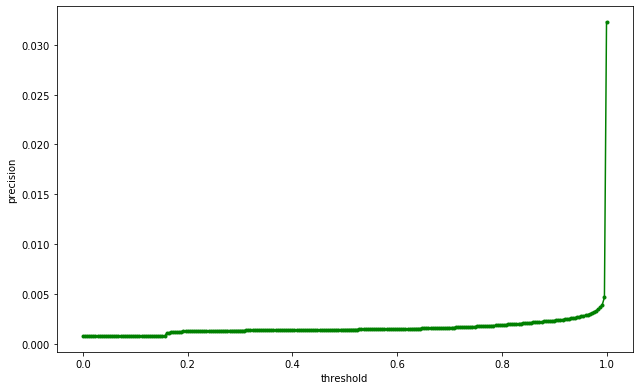

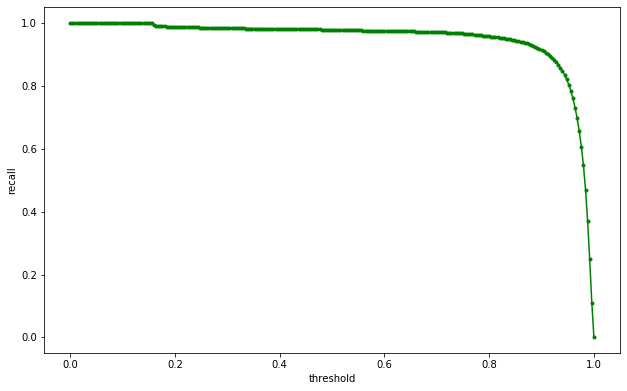

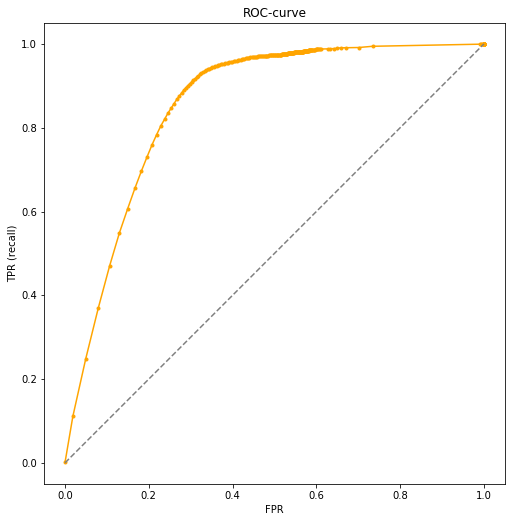

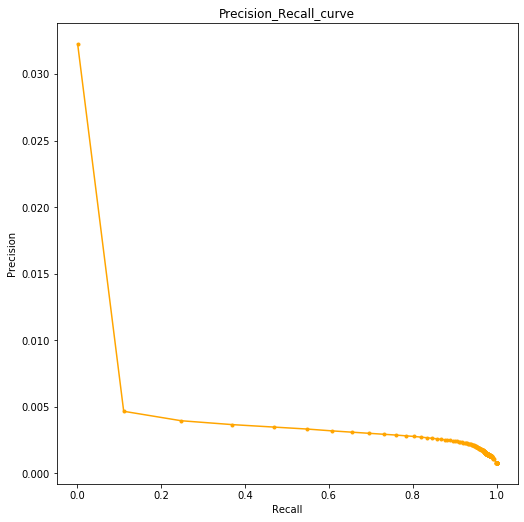

In [33]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e12
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 30000 / 30080


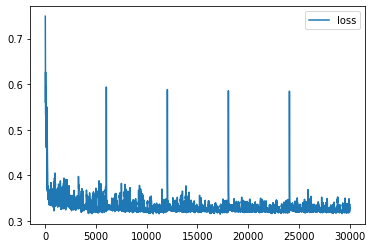


validating . . .



ROC_AUC_score = 0.8587481201171583
AVG_precision_score = 0.003779363547657713


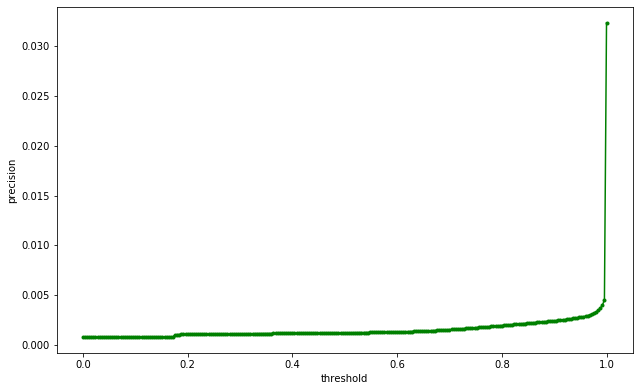

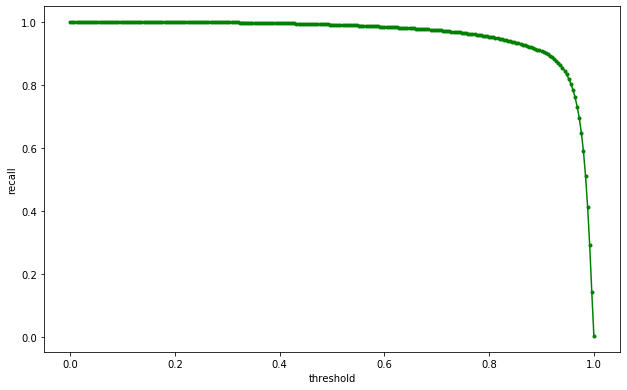

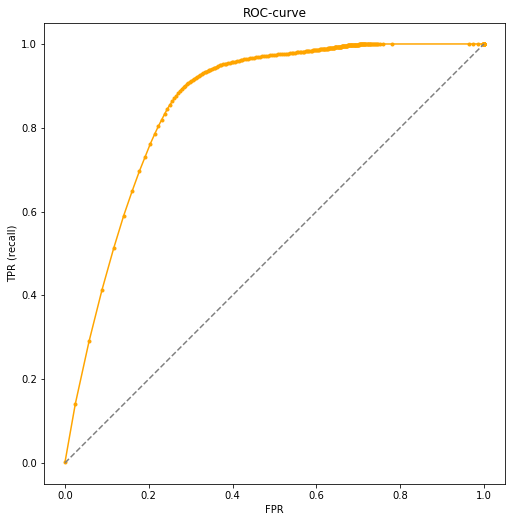

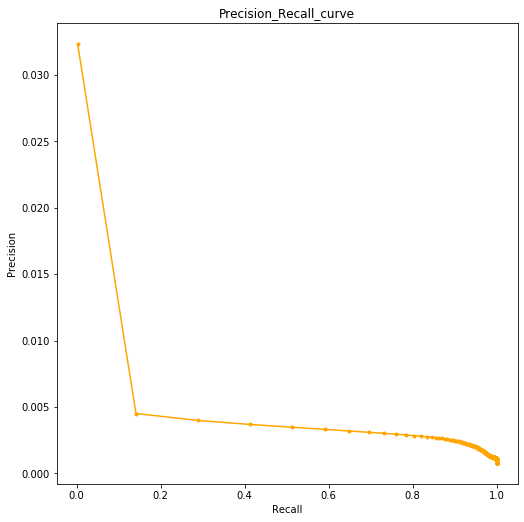

In [66]:
N_CYCLES = 5
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

Done : 60100 / 60160


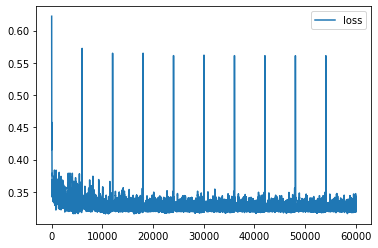


validating . . .



ROC_AUC_score = 0.8494898119637914
AVG_precision_score = 0.0033811731893846775


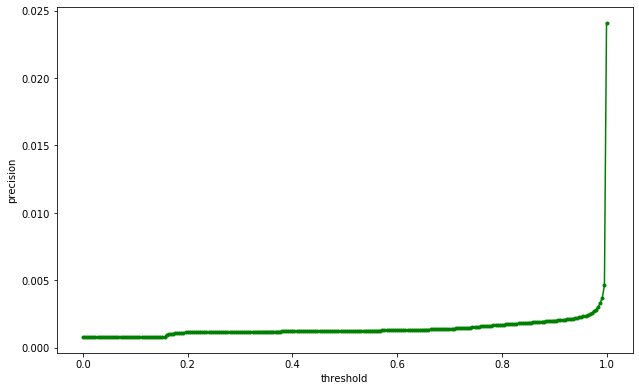

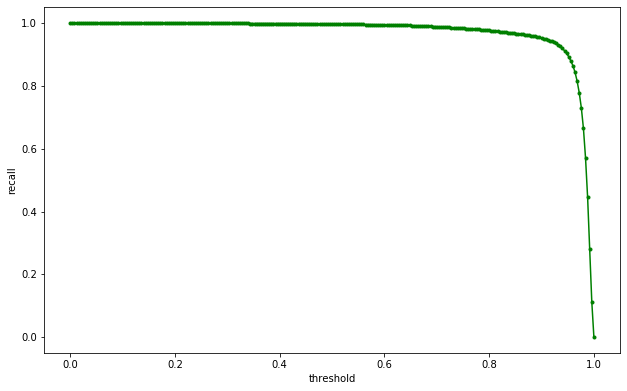

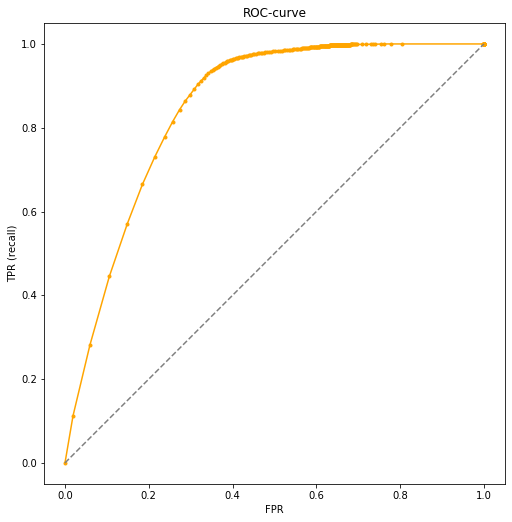

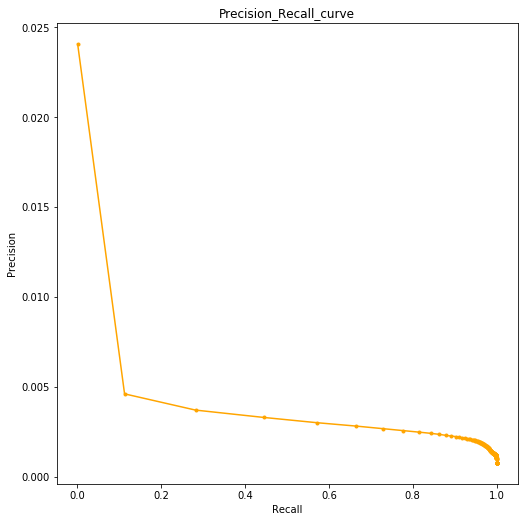

In [67]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 1e-4
LR_DECAY = 5
START_LR_DECAY = 2500
WEIGHT_DECAY = 0
EARTHQUAKE_WEIGHT = 10e7
EMB_SIZE = 16
HID_SIZE = 32
BATCH_SIZE = 1
NUM_WORKERS = 2

pipe = pipeline(
                celled_data_x_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY,
                celled_data_y_path = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                celled_data_path_for_freq_map = CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC,
                n_cells_hor = N_CELLS_HOR, 
                n_cells_ver = N_CELLS_VER,
                model_name = MODEL_MAXMAGN_DENSITY_Xorig_Ywithoutaft,
                testing_days = TESTING_DAYS,
                heavy_quake_thres = HEAVY_QUAKE_THRES,
                days_to_predict_before = DAYS_TO_PREDICT_BEFORE,
                days_to_predict_after = DAYS_TO_PREDICT_AFTER,
                embedding_size = EMB_SIZE,
                hidden_state_size = HID_SIZE,
                n_cycles = N_CYCLES,
                learning_rate = LEARNING_RATE,
                earthquake_weight = EARTHQUAKE_WEIGHT,
                lr_decay = LR_DECAY,
                start_lr_decay = START_LR_DECAY,
                weight_decay = WEIGHT_DECAY,
                device = device,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS
             )

pipe()

| data | X | Y | ROC_AUC | AVG_precision |
| --- | --- | --- | --- | --- |
| <b> magnitude map + density </b> | <b> orig </b> | <b> orig </b> | <b> 0.890 </b> | <b> 0.021 </b> |
| magnitude map + density | orig | without aft | 0.850 | 0.003 |
| magnitude map + density | without aft | orig | 0.845 | 0.01 |
| magnitude map + density | without aft | without aft | 0.859 | 0.004 |